## Exploratory Data Analysis
### ML Crash Course 2023 / RecSys // Suchkova Natalia М8О - 214М - 22
dec 2023 @ MAI IT-Center

>Построение рекомендательной системы на основы данных [Delivery Hero Recommendation Dataset](https://drive.google.com/file/d/12N6iHczXIVX4E_KM15jxeJ_7WQ2urHFq/view).
>
>Выбранная локация - **Сингапур**
>
>Этот ноутбук выполнялся на локалке и данные были скачаны в репозиторий, но лучше их доставать из гугл хранилища по [ссылке](https://drive.google.com/drive/folders/1v0oiDUUlZqhvtloymUYT5LmMeSqzrNEP). *Папка ml_crash_course, data_sg - Cингапур, data_se - Cтокгольм*

#### Load Libraries

In [103]:
# pip install pandarallel

In [104]:
# pip install translate

In [639]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=16)

from IPython.display import clear_output
from translate import Translator

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [707]:
print(plt.style.available)
plt.style.use('seaborn-v0_8')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [719]:
# import matplotlib.colors as colors
# import matplotlib.cm as cmx

In [640]:
PATH = 'C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data/'

In [641]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [722]:
def count_cross_plot(df_k, col_base, col_dop, agg='count', cmap='Set2'):
    df = pd.pivot_table(
        df_k[['order_id', col_base, col_dop]],
        columns=col_base,
        index=col_dop,
        aggfunc=agg
    ).reset_index()

    df.columns = [col if col != '' else key for key, col in df.columns]

    df.plot(
        x='geohash', 
        kind='barh', 
        figsize=(18, 0.4 * df['geohash'].shape[0]),
        title=f'Distribution of {col_base} over {col_dop}\n',
        xlabel='frequency',
        width=0.9,
        edgecolor='black',
        lw=0.4, 
        cmap=cmap
        ) 

#### Load Data

In [642]:
# # Для Google Colab подключения к гугл диску
# collab_env = True
# if collab_env:
#     from google.colab import drive

#     ROOT_DIR = '/content/drive'
#     RANDOM_SEED = 42
#     drive.mount(ROOT_DIR)
#     DRIVE_DATA_DIR = 'ml_crash_course'
#     root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', DRIVE_DATA_DIR)
# else:
#     # in the case of local file systen
#     root_data_dir = '/srv/data/'

# clear_output()
# data_version = '2023_08_06'
# print()
# print("Content in root_data_dir %s:\n%s" % (root_data_dir, [i for i in os.listdir(root_data_dir)]))

In [643]:
# для гугл колаб
# !ls /content/drive/MyDrive/ml_crash_course/data_sg

Ниже приведено описание фич из всех датасетов.

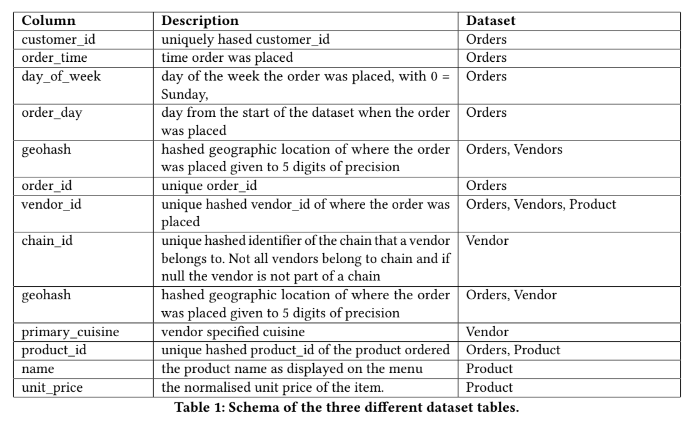

Фичи распределены следующим образом:

Датасет interactions - `Orders`:

- `customer_id`
- `order_time`
- `day_of_week`
- `order_day`
- `geohash`
- `order_id`
- `vendor_id`

Датасет item фич `Products`:

- `vendor_id`
- `product_id`
- `name`
- `unit_price`

Вместо датасета user user фич у нас `Vendors`:

- `vendor_id`
- `chain_id`
- `geohash`
- `primary_cuisine`

## Descriptive DA

Прежде чем приступать к исследованию особенностей данных, необходимо произвести общий анализ данных на предмет пропущенных значений, выбросов, дубликатов и несоответствующих типов данных, а также последующую их предобработку. Для этого ознакомимся с базовыми статистиками и графическим представлением некоторых юзер-айтем фич.

In [644]:
def dda(file_name):
    if ('train' in file_name)  or ('test' in file_name):
        pass
    else:
        ds = pd.read_csv(os.path.join(PATH, 'data_sg', file_name))

        print(color.BOLD + color.GREEN + f'\n-------------------- DDA of {file_name} dataset -----------------------\n' + color.END)

        print(f'The given dataset of {file_name} contains {ds.shape[0]} rows and {ds.shape[1]} columns.\n')

        print('Showing ds info\n')
        display(ds.info())
        print('\n')

        try:
            assert all(ds['Unnamed: 0'] == ds.index)
            ds = ds.drop(ds.columns[0], axis=1)
        except AssertionError:
            print(f'\nThere is df index and column "Unnamed: 0" mismatch in {file_name}')
            display(ds[ds['Unnamed: 0'] != ds.index])
            ds = ds.set_index('Unnamed: 0', drop=False)
            assert all(ds['Unnamed: 0'] == ds.index)
            ds = ds.drop(ds.columns[0], axis=1)

        for col in ds.columns:
            if col in ['customer_id', 'vendor_id', 'product_id', 'chain_id']:
                ds[col] = ds[col].astype(str)
            elif col == 'order_id':
                ds[col] = ds[col].astype(int)

        print('Showing a sum of NaN values by column\n')
        display(ds.isna().sum())
        print('\n')

        numerical_data = ds.select_dtypes(include='number')
        numerical_features=numerical_data.columns.tolist()
        print(f'There are {len(numerical_features)} numerical features in {file_name}:')
        print(numerical_features)

        categorical_data=ds.select_dtypes(include='object')
        categorical_features=categorical_data.columns.tolist()
        print(f'There are {len(categorical_features)} categorical features in {file_name}:')
        print(categorical_features, '\n')

        if len(numerical_features) != 0:
            print(color.BOLD + color.PURPLE + '\n----------- Numerical Features Analysis -----------\n' + color.END)
            print('Showing descriptive stats of numerical columns\n')
            display(numerical_data.describe().T)
            print('\n')

            print('Showing variance of numerical columns\n')
            display(numerical_data.var())
            print('\n')

            print('Showing skew of numerical columns\n')
            display(numerical_data.skew())
            print('\n')

            print('Showing number of unique values in each of numerical features\n')
            display(numerical_data.nunique())
            print('\n')

            print('Showing dist histograms of numerical features\n')
            numerical_data.hist(figsize=(14, 6), bins=20, color='salmon')
            plt.show()


        if len(categorical_features) != 0:
            print(color.BOLD + color.BLUE + '\n----------- Categorical Features Analysis -----------\n' + color.END)
            print('Showing descriptive stats of categorical columns\n')
            display(categorical_data.describe(include='object').T)
            print('\n')

            unique_counts=categorical_data.nunique()
            for index, i in enumerate(range(len(unique_counts))):
                print(index, f'{categorical_features[i]} has {unique_counts[i]} unique values')
                if unique_counts[i] < 100:
                    print()
                    print(f"\033[1m{categorical_features[i]}\033[0m\n")
                    plt.figure(figsize=(18, 6))
                    categorical_data[categorical_features[i]].value_counts().sort_index().plot(kind='bar', color='magenta', rot=90, xlabel=categorical_features[i], ylabel='count')
                    plt.show()

        ds.to_pickle(f'{file_name.split(".")[0]}')


In [645]:
# для гугл колаб
# os.chdir('/content/drive/MyDrive/ml_crash_course/data_sg')

Посмотрим на общие описательные статистики и визуальное представление фич.


-------------------- DDA of C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\orders_sg.txt dataset -----------------------

The given dataset of C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\orders_sg.txt contains 4023005 rows and 9 columns.

Showing ds info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4023005 entries, 0 to 4023004
Data columns (total 9 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   Unnamed: 0   int64 
 1   customer_id  object
 2   geohash      object
 3   order_id     int64 
 4   vendor_id    object
 5   product_id   object
 6   day_of_week  int64 
 7   order_time   object
 8   order_day    object
dtypes: int64(3), object(6)
memory usage: 276.2+ MB


None



Showing a sum of NaN values by column



customer_id    0
geohash        0
order_id       0
vendor_id      0
product_id     0
day_of_week    0
order_time     0
order_day      0
dtype: int64



There are 2 numerical features in C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\orders_sg.txt:
['order_id', 'day_of_week']
There are 6 categorical features in C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\orders_sg.txt:
['customer_id', 'geohash', 'vendor_id', 'product_id', 'order_time', 'order_day'] 


----------- Numerical Features Analysis -----------

Showing descriptive stats of numerical columns



,count,mean,std,min,25%,50%,75%,max
order_id,4023005.0,994522.623503,580784.271794,0.0,490439.0,986525.0,1500777.0,1999999.0
day_of_week,4023005.0,3.229277,2.014137,0.0,1.0,3.0,5.0,6.0




Showing variance of numerical columns



order_id       3.373104e+11
day_of_week    4.056749e+00
dtype: float64



Showing skew of numerical columns



order_id       0.020994
day_of_week   -0.143856
dtype: float64



Showing number of unique values in each of numerical features



order_id       2000000
day_of_week          7
dtype: int64



Showing dist histograms of numerical features



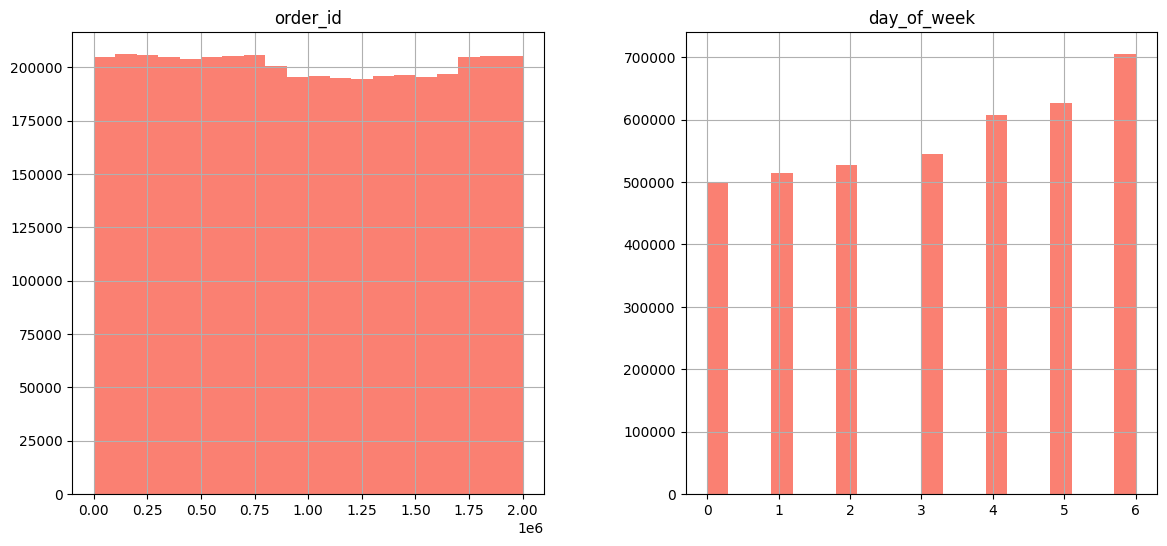


----------- Categorical Features Analysis -----------

Showing descriptive stats of categorical columns



,count,unique,top,freq
customer_id,4023005,512916,50acf8536f,691
geohash,4023005,45,w21z6,420840
vendor_id,4023005,7411,709e5409,6704
product_id,4023005,256502,ecc84756562d,803
order_time,4023005,82013,12:11:34,206
order_day,4023005,91,28 days,63454


C:\Users\User\AppData\Local\Temp\ipykernel_14676\2965755306.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(index, f'{categorical_features[i]} has {unique_counts[i]} unique values')
C:\Users\User\AppData\Local\Temp\ipykernel_14676\2965755306.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if unique_counts[i] < 100:


0 customer_id has 512916 unique values
1 geohash has 45 unique values

geohash



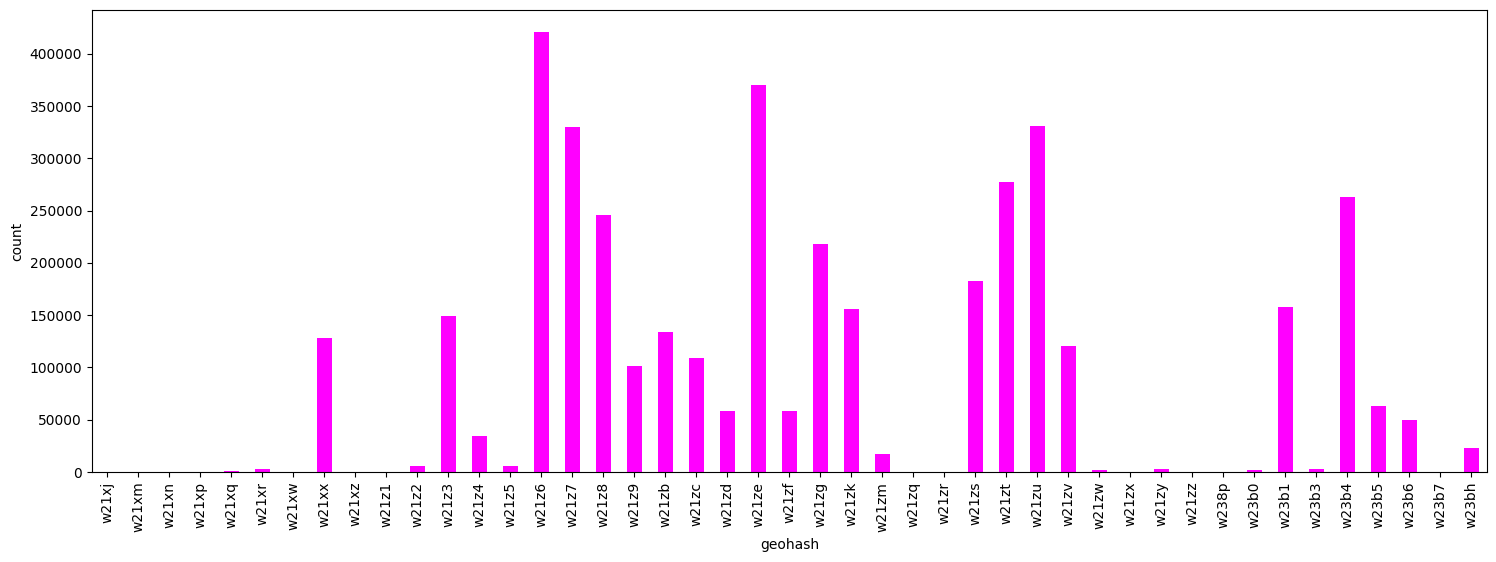

C:\Users\User\AppData\Local\Temp\ipykernel_14676\2965755306.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(index, f'{categorical_features[i]} has {unique_counts[i]} unique values')
C:\Users\User\AppData\Local\Temp\ipykernel_14676\2965755306.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if unique_counts[i] < 100:


2 vendor_id has 7411 unique values
3 product_id has 256502 unique values
4 order_time has 82013 unique values
5 order_day has 91 unique values

order_day



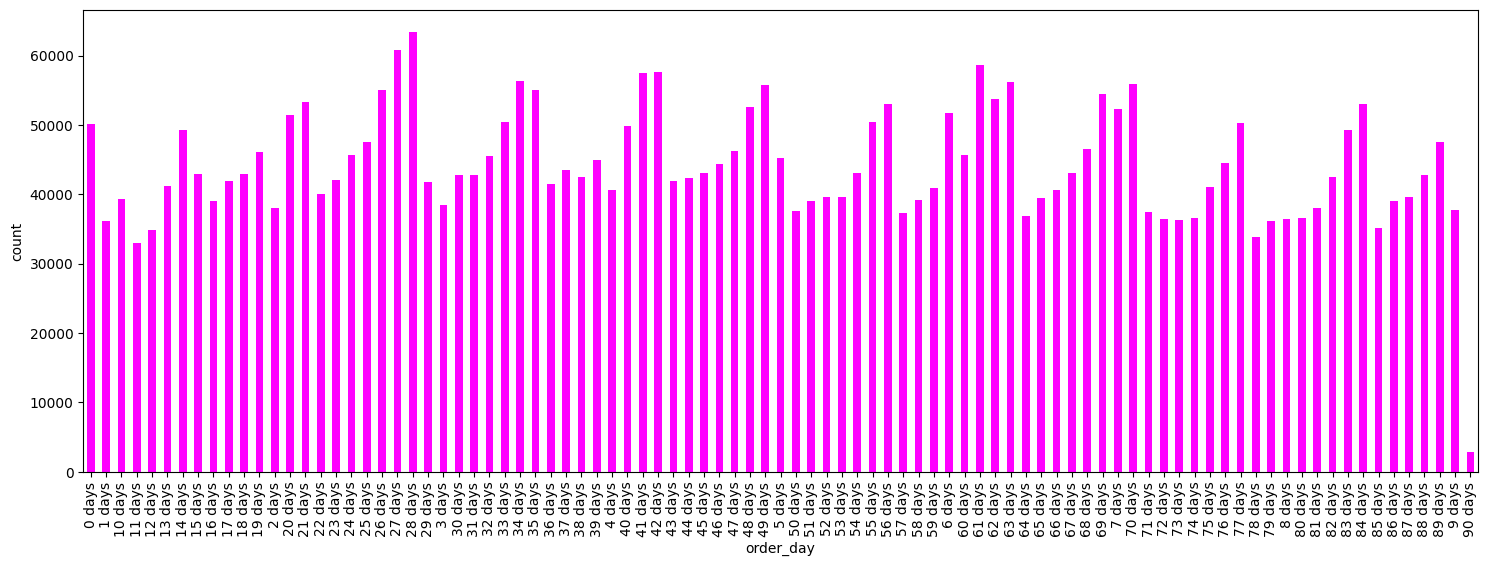


-------------------- DDA of C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\products_sg.txt dataset -----------------------

The given dataset of C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\products_sg.txt contains 1066840 rows and 5 columns.

Showing ds info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066840 entries, 0 to 1066839
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  1066840 non-null  int64  
 1   vendor_id   1066840 non-null  object 
 2   product_id  1066840 non-null  object 
 3   name        1066800 non-null  object 
 4   unit_price  1066840 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 40.7+ MB


None



Showing a sum of NaN values by column



vendor_id      0
product_id     0
name          40
unit_price     0
dtype: int64



There are 1 numerical features in C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\products_sg.txt:
['unit_price']
There are 3 categorical features in C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\products_sg.txt:
['vendor_id', 'product_id', 'name'] 


----------- Numerical Features Analysis -----------

Showing descriptive stats of numerical columns



,count,mean,std,min,25%,50%,75%,max
unit_price,1066840.0,0.003751,0.008651,0.0,0.0,0.0024,0.0044,1.0




Showing variance of numerical columns



unit_price    0.000075
dtype: float64



Showing skew of numerical columns



unit_price    31.933794
dtype: float64



Showing number of unique values in each of numerical features



unit_price    446
dtype: int64



Showing dist histograms of numerical features



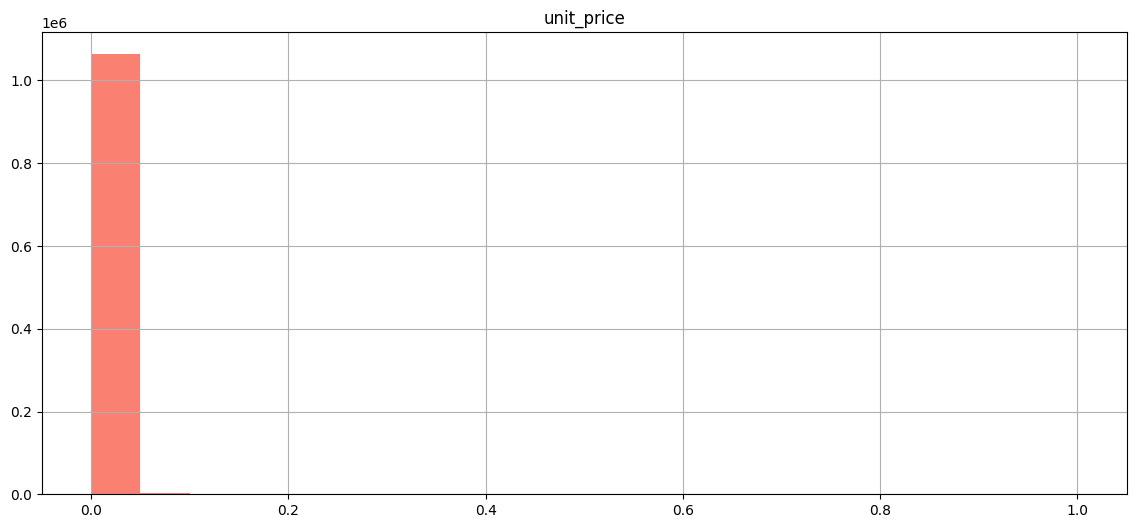


----------- Categorical Features Analysis -----------

Showing descriptive stats of categorical columns



,count,unique,top,freq
vendor_id,1066840,7411,7bf10d94,1254
product_id,1066840,1066823,f96cd0f8cb41,2
name,1066800,274914,Coke,1685


C:\Users\User\AppData\Local\Temp\ipykernel_14676\2965755306.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(index, f'{categorical_features[i]} has {unique_counts[i]} unique values')
C:\Users\User\AppData\Local\Temp\ipykernel_14676\2965755306.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if unique_counts[i] < 100:


0 vendor_id has 7411 unique values
1 product_id has 1066823 unique values
2 name has 274914 unique values

-------------------- DDA of C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\vendors_sg.txt dataset -----------------------

The given dataset of C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\vendors_sg.txt contains 7411 rows and 5 columns.

Showing ds info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7411 entries, 0 to 7410
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       7411 non-null   int64 
 1   vendor_id        7411 non-null   object
 2   chain_id         5912 non-null   object
 3   geohash          7411 non-null   object
 4   primary_cuisine  7411 non-null   object
dtypes: int64(1), object(4)
memory usage: 289.6+ KB


None




There is df index and column "Unnamed: 0" mismatch in C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\vendors_sg.txt


,Unnamed: 0,vendor_id,chain_id,geohash,primary_cuisine
2,4,03eb25e1,5055ab25,w21ze,bak kut teh
3,5,3613129a,8984acb6,w23b1,italian
4,7,0946c9e5,1e3a2913,w21z4,bak kut teh
5,13,89188652,NaN,w21z7,laksa
6,16,e05cc628,NaN,w21z3,tea
...,...,...,...,...,...
7406,17798,2d0b2dfb,1a3564c8,w21zt,mala xiang guo
7407,17799,15bbf316,434020fb,w21zs,mala xiang guo
7408,17801,a1f11221,b5431702,w21zu,mala xiang guo
7409,17803,6268886c,0f494195,w21z8,mala xiang guo


Showing a sum of NaN values by column



vendor_id          0
chain_id           0
geohash            0
primary_cuisine    0
dtype: int64



There are 0 numerical features in C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\vendors_sg.txt:
[]
There are 4 categorical features in C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\vendors_sg.txt:
['vendor_id', 'chain_id', 'geohash', 'primary_cuisine'] 


----------- Categorical Features Analysis -----------

Showing descriptive stats of categorical columns



,count,unique,top,freq
vendor_id,7411,7411,b160c319,1
chain_id,7411,1855,nan,1499
geohash,7411,31,w21z7,1309
primary_cuisine,7411,78,chinese,770




0 vendor_id has 7411 unique values
1 chain_id has 1855 unique values
2 geohash has 31 unique values

geohash



C:\Users\User\AppData\Local\Temp\ipykernel_14676\2965755306.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(index, f'{categorical_features[i]} has {unique_counts[i]} unique values')
C:\Users\User\AppData\Local\Temp\ipykernel_14676\2965755306.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if unique_counts[i] < 100:


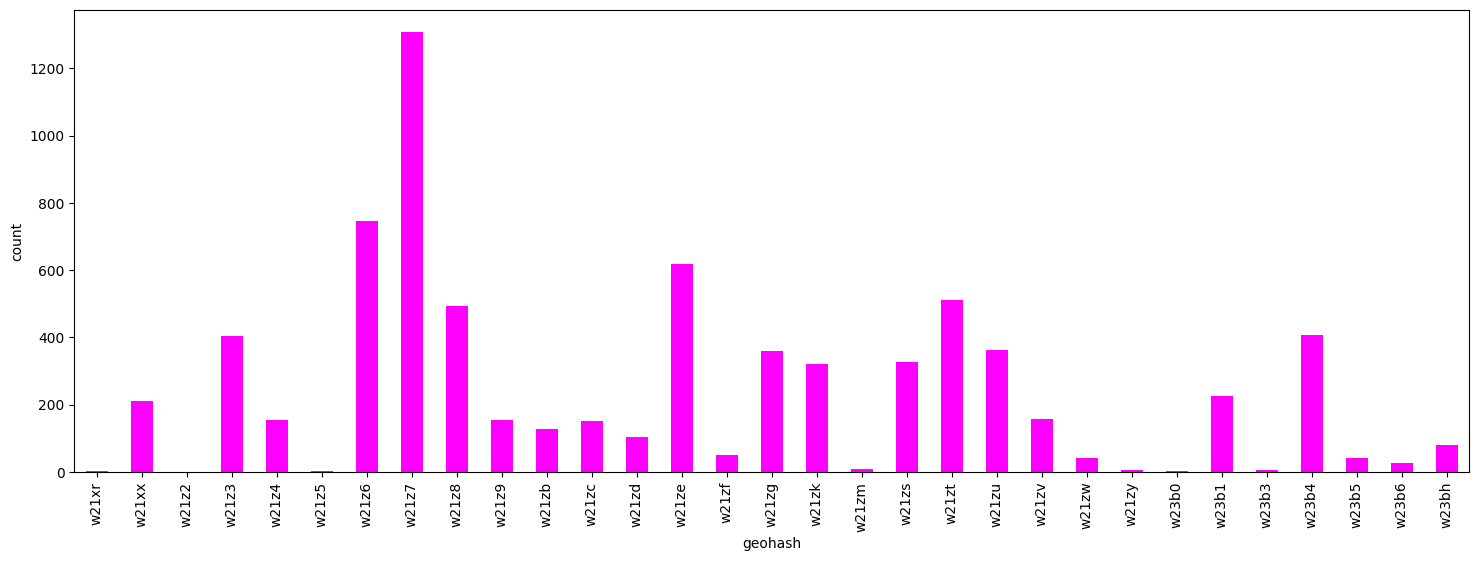

C:\Users\User\AppData\Local\Temp\ipykernel_14676\2965755306.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(index, f'{categorical_features[i]} has {unique_counts[i]} unique values')
C:\Users\User\AppData\Local\Temp\ipykernel_14676\2965755306.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if unique_counts[i] < 100:


3 primary_cuisine has 78 unique values

primary_cuisine



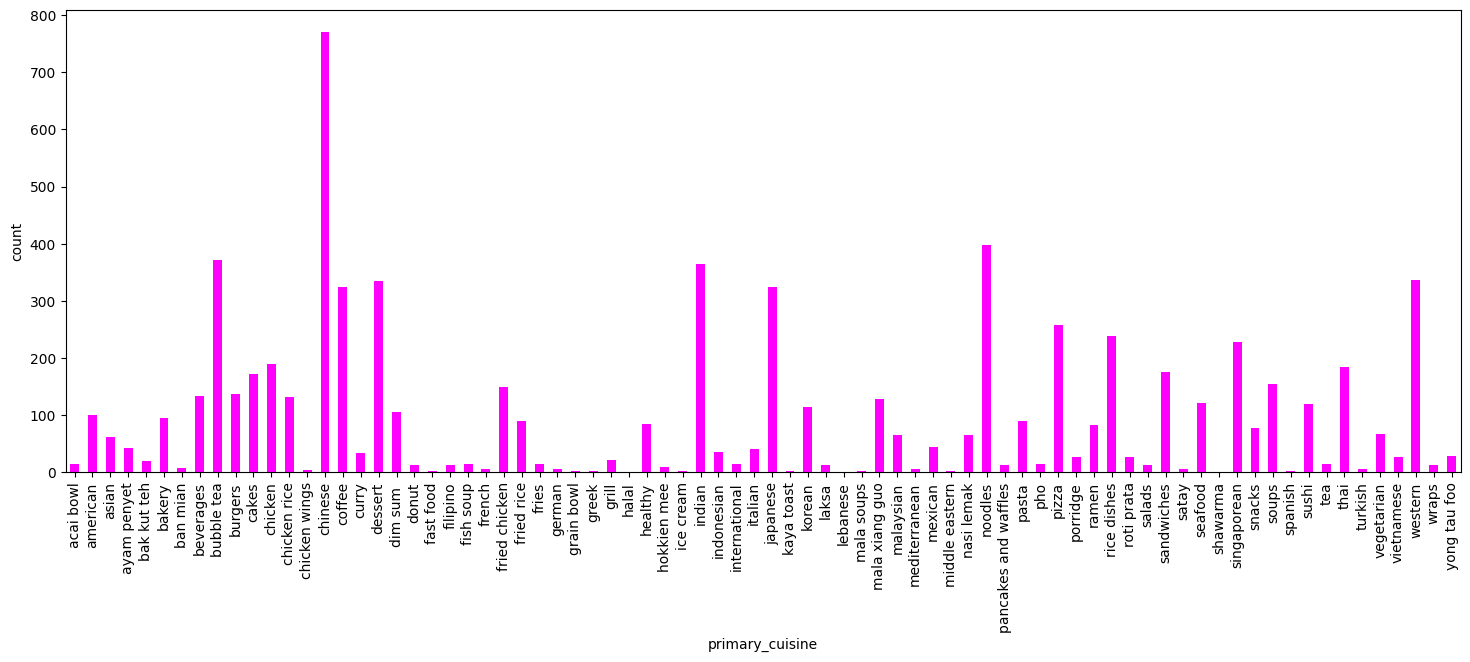

In [646]:
for i in [i for i in glob.glob(PATH + '*.{}'.format('txt'))]:
    dda(i)

**Замечания**
- В динамике покупок по дням недели определяется сезонность
- В датасете продуктов есть дубли по product_id
- В именах продуктов есть 40 пропусков
- Не все продукты есть в истории заказов за период
- Территориальное рапсределение заказов не очень равномерное
- Нормализованная **unit_price** имеет крайне длинный правый хвост (коэф смещения == 31.933794) и очень низкое среднее значение = 0.003 - значит большинство цен низкие, но есть несколько товаров, цена которых лежит на верзней границе диапазона. возможно, их придется выкинуть из анализа


### Check IDs, Uniqueness, Duplicates, Data Types, Data Shapes etc.

In [647]:
%%time
orders_sg = pd.read_pickle('data/orders_sg')
products_sg = pd.read_pickle('data/products_sg')
vendors_sg = pd.read_pickle('data/vendors_sg')

CPU times: total: 4.3 s
Wall time: 4.64 s


Смотрим на наборы связующих id между датасетами.

In [648]:
orders_sg[[col for col in orders_sg.columns if 'id' in col]]

,customer_id,order_id,vendor_id,product_id
0,1ba124d4e5,0,212753d2,783e85338f1c
1,1ba124d4e5,0,212753d2,084ab73246e6
2,1ba124d4e5,0,212753d2,30eba3cc2676
3,1ba124d4e5,0,212753d2,3910309eea60
4,1ba124d4e5,0,212753d2,20049fb602cb
...,...,...,...,...
4023000,7e3554a009,1999998,ff0edd9f,7602ccd87eea
4023001,7e3554a009,1999998,ff0edd9f,91129b65ae92
4023002,7e3554a009,1999999,2bba6450,7bb67a5dd524
4023003,7e3554a009,1999999,2bba6450,d40fe2db522c


In [649]:
products_sg[[col for col in products_sg.columns if 'id' in col]]

,vendor_id,product_id
0,15bbf316,59099e089514
1,e7b24dc0,52e1017fdbd9
2,e7b24dc0,fcb7110cd932
3,7112a20b,d3e7708c2bc9
4,6137ef21,bf0d5ac0e03c
...,...,...
1066835,3a3422b7,74792a33ac62
1066836,1ee69614,c782aedb62ae
1066837,67499b6a,59537c172b6a
1066838,f444f459,c999a7a4b2f5


In [650]:
vendors_sg[[col for col in vendors_sg.columns if 'id' in col]]

,vendor_id,chain_id
Unnamed: 0,,
0,b160c319,d2786168
1,9c8f010e,d2786168
4,03eb25e1,5055ab25
5,3613129a,8984acb6
7,0946c9e5,1e3a2913
...,...,...
17798,2d0b2dfb,1a3564c8
17799,15bbf316,434020fb
17801,a1f11221,b5431702


Проверяем верно ли сменили типы данных.

In [651]:
orders_sg.dtypes

customer_id    object
geohash        object
order_id        int32
vendor_id      object
product_id     object
day_of_week     int64
order_time     object
order_day      object
dtype: object

In [652]:
products_sg.dtypes

vendor_id      object
product_id     object
name           object
unit_price    float64
dtype: object

In [653]:
vendors_sg.dtypes

vendor_id          object
chain_id           object
geohash            object
primary_cuisine    object
dtype: object

Начальные количества уникальных значений.

In [654]:
orders_sg.nunique()

customer_id     512916
geohash             45
order_id       2000000
vendor_id         7411
product_id      256502
day_of_week          7
order_time       82013
order_day           91
dtype: int64

In [655]:
products_sg.nunique()

vendor_id        7411
product_id    1066823
name           274914
unit_price        446
dtype: int64

In [656]:
vendors_sg.nunique()

vendor_id          7411
chain_id           1855
geohash              31
primary_cuisine      78
dtype: int64

In [657]:
# orders_sg[['customer_id', 'vendor_id', 'product_id']] = orders_sg[['customer_id', 'vendor_id', 'product_id']].astype(str)
# orders_sg['order_id'] = orders_sg['order_id'].astype(int)

# products_sg[['vendor_id', 'product_id']] = products_sg[['vendor_id', 'product_id']].astype(str)
# vendors_sg[['vendor_id', 'chain_id']] = vendors_sg[['vendor_id', 'chain_id']].astype(str)

#### Check Orders DS (Iteractions)

In [658]:
orders_sg['order_time'] = orders_sg['order_time'].astype(str)
orders_sg['order_day'] = orders_sg['order_day'].astype(str)
orders_sg.geohash = orders_sg.geohash.astype(str)

In [659]:
# для удобства сделаем еще числовую яичу из порядкового номера дня заказа
orders_sg['order_day_int'] = orders_sg['order_day'].parallel_apply(lambda x: int(x.replace(' days', '')))

In [660]:
orders_sg.shape

(4023005, 9)

##### Dupl

In [661]:
orders_sg.duplicated(['order_id']).sum()

2023005

Наличие дубликатов в orders_sg еще ни о чем не говорит, так как датасет заказов представляет собой набор уникальных взаимодействий заказчика с каждым продуктом, а в заказе обычно бывает несколько продуктов.

In [508]:
orders_sg.duplicated().sum()

99521

А вот то что в датасете есть полные дубликаты уже говорит о том, что либо это ошибочные дубли, либо о том, что в заказах было по несколько одинаковых товаров

In [509]:
orders_sg[orders_sg.duplicated(keep=False)].sort_values(['order_id', 'product_id'])

,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day,order_day_int
30,2e7276ad3a,w21z6,6,54a7bf39,badd0863a0a4,2,20:40:24,87 days,87
31,2e7276ad3a,w21z6,6,54a7bf39,badd0863a0a4,2,20:40:24,87 days,87
90,60cd03df0e,w21ze,39,94027f7b,20492c73b999,3,12:20:15,46 days,46
91,60cd03df0e,w21ze,39,94027f7b,20492c73b999,3,12:20:15,46 days,46
97,ac21229e07,w21zk,43,f06df501,6a0685044984,6,18:38:11,77 days,77
...,...,...,...,...,...,...,...,...,...
4022970,2d986ed47a,w23b1,1999983,64bc8b44,e0de4253f716,3,11:12:47,53 days,53
4022971,2d986ed47a,w23b1,1999983,64bc8b44,e0de4253f716,3,11:12:47,53 days,53
4022975,83e881ee83,w21z7,1999986,b984a610,d31dbe57757b,0,19:09:36,43 days,43
4022976,83e881ee83,w21z7,1999986,b984a610,d31dbe57757b,0,19:09:36,43 days,43


К обработке дубликатов датасета заказов мы подойдем в конце, когда соберем все датасеты вместе.

##### geohash

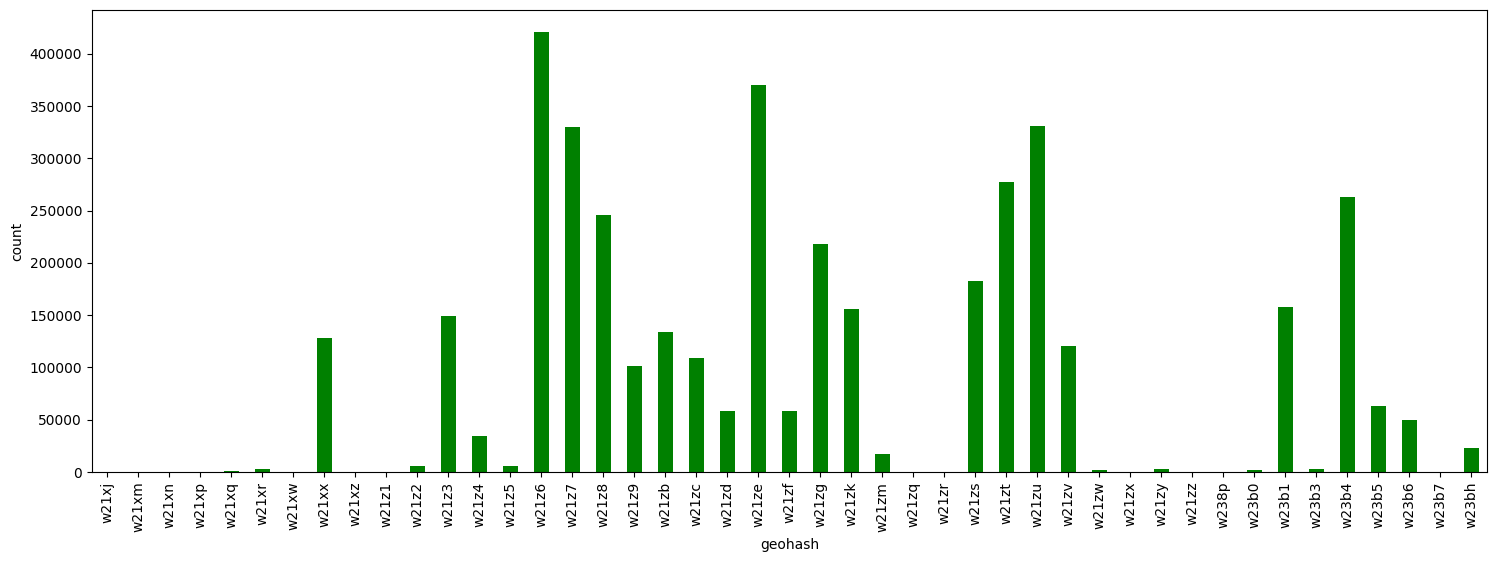

In [666]:
plt.figure(figsize=(18, 6))
orders_sg['geohash'].value_counts().sort_index().plot(kind='bar', color='green', rot=90, xlabel='geohash', ylabel='count')
plt.show()

Самый часто появлявшийся адрес находился в гексагоне w21z6, w21ze. Наверное, находятся в центре города.

Также интересно понять, как геохэши расположены относительно друг друга.

##### Week Day

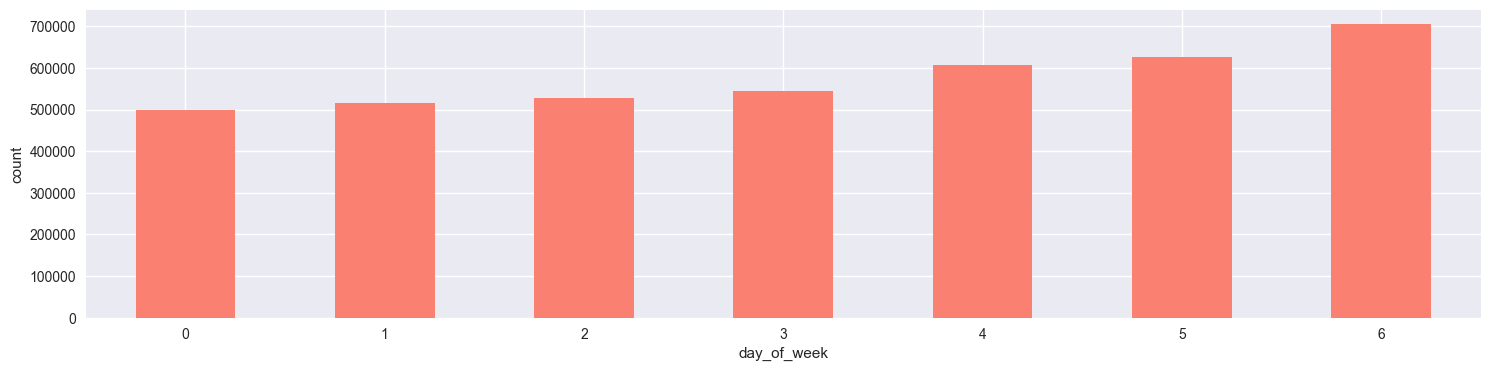

In [724]:
# orders_sg.day_of_week.hist(figsize=(18, 4), bins=20, color='salmon')
plt.figure(figsize=(18, 4))
orders_sg['day_of_week'].value_counts().sort_index().plot(kind='bar', rot=0, color='salmon', xlabel='day_of_week', ylabel='count')
plt.show()

Суббота самый популярный день для покупок.

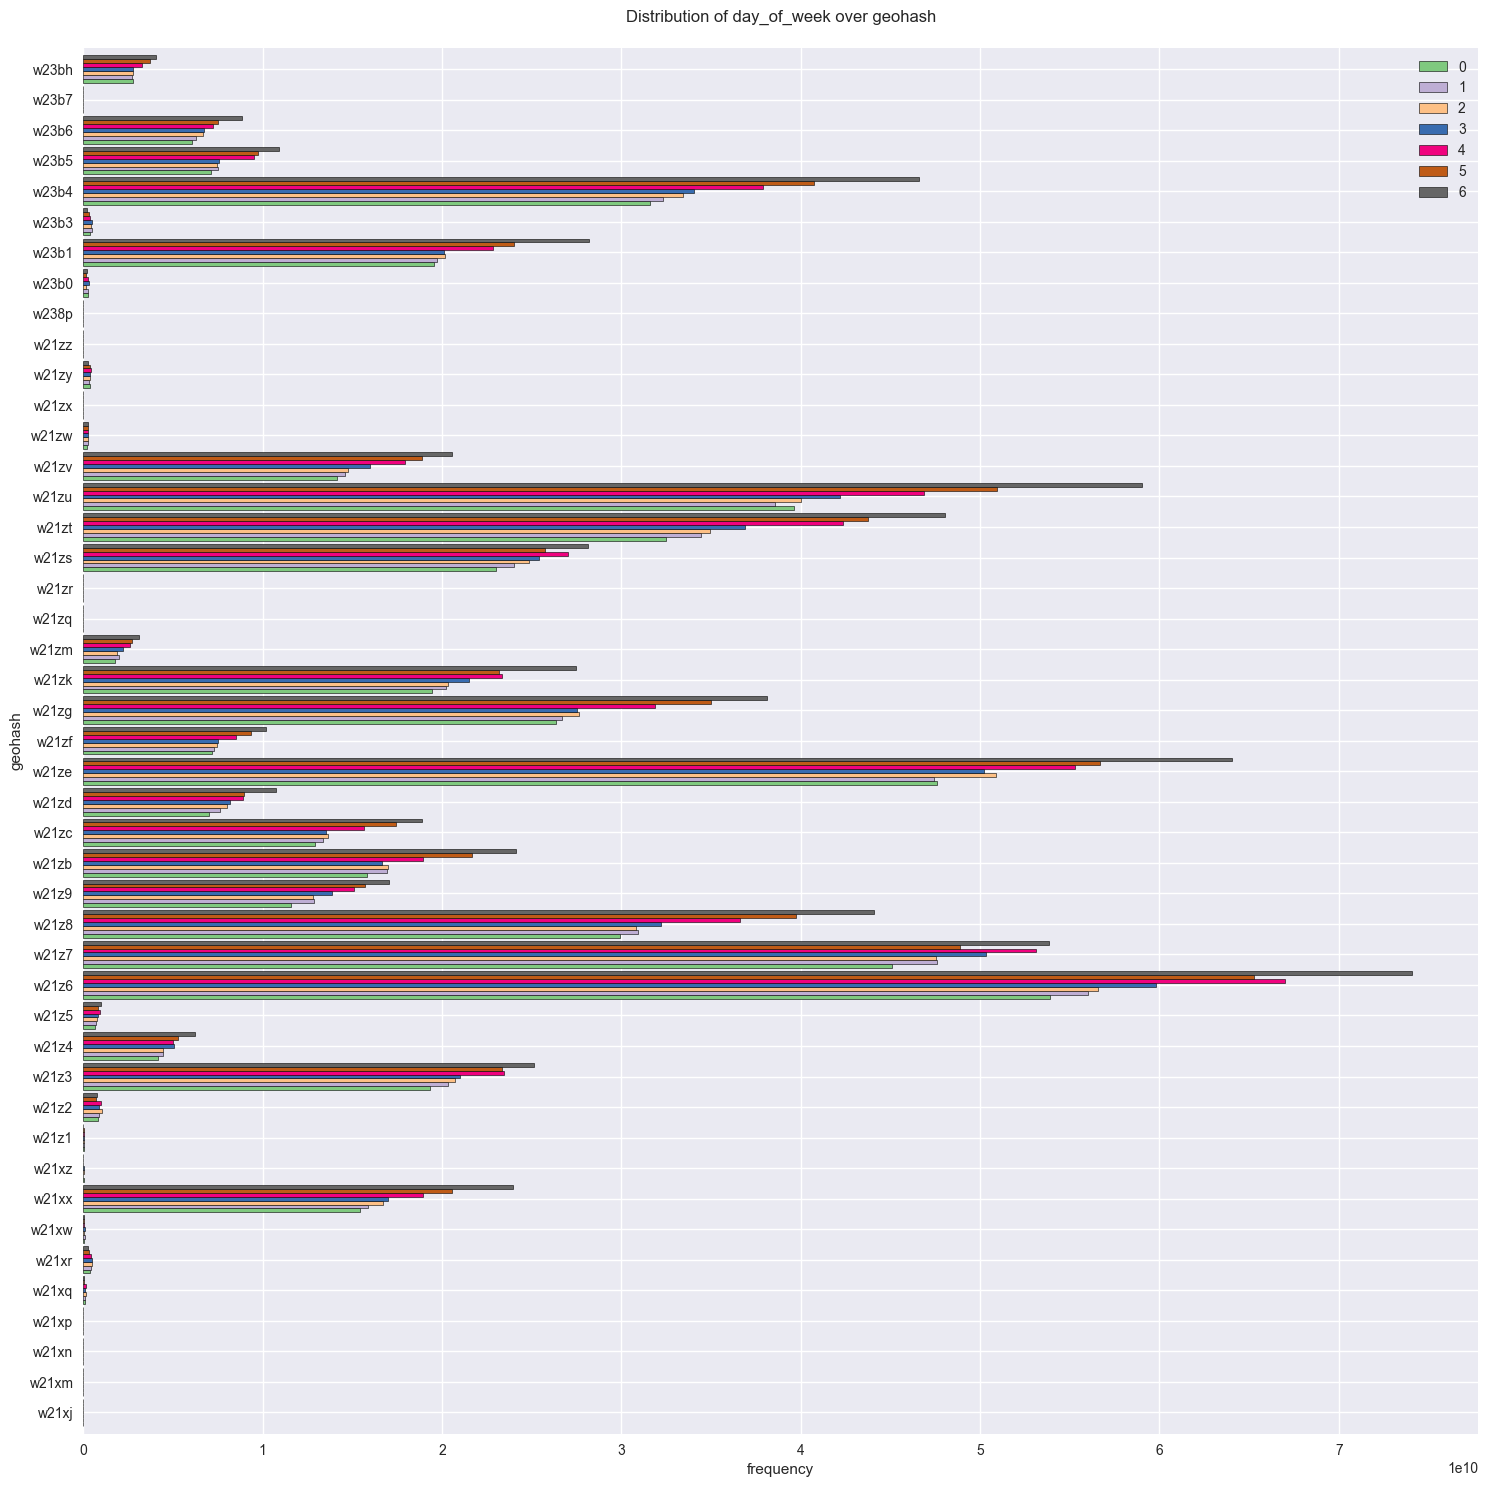

In [725]:
count_cross_plot(orders_sg, 'day_of_week', 'geohash', 'sum', 'Accent')

#### Check Products DS and Products Interactions

In [602]:
f'Видим, что всего в датасете продуктов есть {products_sg.product_id.nunique()} уникальных айтема, тогда как в заказах есть всего {orders_sg.product_id.nunique()} товара, что **составляет {orders_sg.product_id.nunique()/products_sg.product_id.nunique() * 100 :.3f}%**'

'Видим, что всего в датасете продуктов есть 1066823 уникальных айтема, тогда как в заказах есть всего 256502 товара, что **составляет 24.044%**'

Видим, что всего в датасете продуктов есть 1066823 уникальных айтема, тогда как в заказах есть всего 256502 товара, что **составляет 24.044%** от всего множества продуктов.

Выше мы видели что в датасете есть пропуски в поле имени:

In [603]:
products_sg.isna().sum()

vendor_id      0
product_id     0
name          40
unit_price     0
dtype: int64

In [604]:
products_sg[products_sg.name.isna()]

,vendor_id,product_id,name,unit_price
110680,14503eb0,f711e7246c3d,NaN,0.0
119303,87fdc8b2,4e6fdcef49b0,NaN,0.0
125159,7556d120,c7526f62c0fd,NaN,0.0
132537,1c5be2cb,b482c48bd32e,NaN,0.0
135779,4b106f17,040f32e3af42,NaN,0.0
136546,47e46c6a,1cc4483d7eef,NaN,0.0
152681,01b23082,1b9918b019cd,NaN,0.0
331949,ac356557,ce8bce9721ef,NaN,0.0
337989,f04c1db0,c68d31f8fe77,NaN,0.0
342294,375b64e4,ebbed5a13410,NaN,0.0


Удаляем товары без доп данных по имени, так как пропуски в имени и цене к одних и тех же продуктов.

In [605]:
products_sg = products_sg[products_sg.name.notna()]

##### Dupl

In [606]:
products_sg.duplicated().sum()

0

In [607]:
products_sg[['vendor_id', 'product_id']].duplicated().sum()

0

In [608]:
products_sg[['vendor_id', 'name', 'unit_price']].duplicated().sum()

0

In [609]:
products_sg[['product_id', 'name', 'unit_price']].duplicated().sum()

12

In [610]:
products_sg[['product_id', 'name']].duplicated().sum()

15

15 дублей по имени и айди продукта

In [611]:
products_sg[['product_id', 'unit_price']].duplicated().sum()

14

In [612]:
# продукты у которых один айди и имя и цена (но разные вендоры)
# на ких посмотрим позже - это скорее всего смена вендора
products_sg[products_sg[['product_id', 'name', 'unit_price']].duplicated(keep=False)].sort_values('product_id').head(4)

,vendor_id,product_id,name,unit_price
841968,4cf81fe1,032690175d82,I12. Sweet & Sour Sliced Fish with Rice 酸甜生鱼片饭,0.0028
392653,a06f1cbf,032690175d82,I12. Sweet & Sour Sliced Fish with Rice 酸甜生鱼片饭,0.0028
919194,987da7cb,06cbeac1e258,Teriyaki Chicken Burger with French Fries Meal,0.0036
715087,c19e57fb,06cbeac1e258,Teriyaki Chicken Burger with French Fries Meal,0.0036


In [613]:
products_sg[products_sg[['product_id', 'name']].duplicated(keep=False)].sort_values('product_id').head(6)

,vendor_id,product_id,name,unit_price
392653,a06f1cbf,032690175d82,I12. Sweet & Sour Sliced Fish with Rice 酸甜生鱼片饭,0.0028
841968,4cf81fe1,032690175d82,I12. Sweet & Sour Sliced Fish with Rice 酸甜生鱼片饭,0.0028
919194,987da7cb,06cbeac1e258,Teriyaki Chicken Burger with French Fries Meal,0.0036
715087,c19e57fb,06cbeac1e258,Teriyaki Chicken Burger with French Fries Meal,0.0036
606997,a06f1cbf,0e1f455b56a9,I05. Salted Egg Pork Ribs with Rice 咸蛋排骨饭,0.0028
713906,4cf81fe1,0e1f455b56a9,I05. Salted Egg Pork Ribs with Rice 咸蛋排骨饭,0.0028


In [614]:
products_sg[products_sg[['product_id', 'unit_price']].duplicated(keep=False)].sort_values('product_id')#.head(6)

,vendor_id,product_id,name,unit_price
841968,4cf81fe1,032690175d82,I12. Sweet & Sour Sliced Fish with Rice 酸甜生鱼片饭,0.0028
392653,a06f1cbf,032690175d82,I12. Sweet & Sour Sliced Fish with Rice 酸甜生鱼片饭,0.0028
919194,987da7cb,06cbeac1e258,Teriyaki Chicken Burger with French Fries Meal,0.0036
715087,c19e57fb,06cbeac1e258,Teriyaki Chicken Burger with French Fries Meal,0.0036
606997,a06f1cbf,0e1f455b56a9,I05. Salted Egg Pork Ribs with Rice 咸蛋排骨饭,0.0028
713906,4cf81fe1,0e1f455b56a9,I05. Salted Egg Pork Ribs with Rice 咸蛋排骨饭,0.0028
842537,4cf81fe1,2f9ddb3f502c,I02. Dry Curry Sliced Pork with Rice 干咖喱猪肉饭,0.0028
819256,a06f1cbf,2f9ddb3f502c,I02. Dry Curry Sliced Pork with Rice 干咖喱猪肉饭,0.0028
201134,60cde597,370c513a5f54,Haagen Dazs Mini-Tub,0.0024
838206,6e20616b,370c513a5f54,Haagen Dazs Mini-Tub,0.0024


In [615]:
# продукты у которых один айди и имя но разная цена (и вендоры) - смена вендора
set(products_sg[products_sg[['product_id', 'name']].duplicated(keep=False)].product_id) - \
set(products_sg[products_sg[['product_id', 'unit_price']].duplicated(keep=False)].product_id)

{'2c87c973b870', '5b89c2e3313b', 'd1d3db7bc18f'}

In [616]:
# продукты у которых один айди и цена но разные имена (и вендоры) - смена вендора и имени/ошибка в имени
set(products_sg[products_sg[['product_id', 'unit_price']].duplicated(keep=False)].product_id) -\
set(products_sg[products_sg[['product_id', 'name']].duplicated(keep=False)].product_id)

{'370c513a5f54', '5f9cfe69e1db'}

In [617]:
products_sg.duplicated(['product_id']).sum()

17

17 дублей по id

In [618]:
products_sg[products_sg.duplicated(['product_id'], keep=False)].sort_values('product_id')

,vendor_id,product_id,name,unit_price
841968,4cf81fe1,032690175d82,I12. Sweet & Sour Sliced Fish with Rice 酸甜生鱼片饭,0.0028
392653,a06f1cbf,032690175d82,I12. Sweet & Sour Sliced Fish with Rice 酸甜生鱼片饭,0.0028
715087,c19e57fb,06cbeac1e258,Teriyaki Chicken Burger with French Fries Meal,0.0036
919194,987da7cb,06cbeac1e258,Teriyaki Chicken Burger with French Fries Meal,0.0036
713906,4cf81fe1,0e1f455b56a9,I05. Salted Egg Pork Ribs with Rice 咸蛋排骨饭,0.0028
606997,a06f1cbf,0e1f455b56a9,I05. Salted Egg Pork Ribs with Rice 咸蛋排骨饭,0.0028
236011,4cf81fe1,2c87c973b870,I10. Salted Egg Diced Chicken with Rice 咸蛋鸡丁饭,0.0028
608240,a06f1cbf,2c87c973b870,I10. Salted Egg Diced Chicken with Rice 咸蛋鸡丁饭,0.0032
819256,a06f1cbf,2f9ddb3f502c,I02. Dry Curry Sliced Pork with Rice 干咖喱猪肉饭,0.0028
842537,4cf81fe1,2f9ddb3f502c,I02. Dry Curry Sliced Pork with Rice 干咖喱猪肉饭,0.0028


In [619]:
products_sg.duplicated(['vendor_id', 'product_id']).sum()

0

Есть дубли по айди, нет абсолютных дубликатов в продуктах по айди и вендору, что хорошо

Кажется немного странным что у разных вендоров в датасете есть абсолютно идентичные товары по названию и цене, нужна доп информация. Скорее всего это все товары у которых за рассматриваемый период менялся вендор. Позднее мы все равно будем клеить продукты к заказам, тогда будет видно, какие вендоры актуальные для заказов и мы удалим которые не приклеятся из-за смены вендора.

У количество дублей по айди и по имени и айди отличается. 15 дублей по имени и айди, проверим сначала, где еще 2 продукта, которые дубли просто по айди

In [620]:
set(products_sg[products_sg.duplicated(['product_id'], keep=False)].name) - set(products_sg[products_sg.duplicated(['name', 'product_id'], keep=False)].name)

{'Haagen Dazs Mini-Tub',
 'Haagen Dazs Mini-Tub ',
 'I04. Jing Du Pork Ribs with Rice 京都排骨王饭',
 'I04. Kyoto Pork Ribs With Rice 京都排骨王饭'}

В 1 продукте есть опечатка в виде доп пробела, это поправим чтобы не было доп товаров

Во 2 продукте есть различие в названии несмотря на то, что они вроде бы одинаковые

In [621]:
products_sg.loc[products_sg.name == 'Haagen Dazs Mini-Tub ', 'name']  = 'Haagen Dazs Mini-Tub'

In [622]:
products_sg.loc[products_sg.name == 'I04. Jing Du Pork Ribs with Rice 京都排骨王饭']

,vendor_id,product_id,name,unit_price
204539,4cf81fe1,5f9cfe69e1db,I04. Jing Du Pork Ribs with Rice 京都排骨王饭,0.0028
416581,7bcc735a,14a828fd7ca5,I04. Jing Du Pork Ribs with Rice 京都排骨王饭,0.0028


In [623]:
products_sg.loc[products_sg.name == 'I04. Kyoto Pork Ribs With Rice 京都排骨王饭']

,vendor_id,product_id,name,unit_price
392374,a06f1cbf,5f9cfe69e1db,I04. Kyoto Pork Ribs With Rice 京都排骨王饭,0.0028
393391,7bcc735a,db9ea30b4a0f,I04. Kyoto Pork Ribs With Rice 京都排骨王饭,0.0028


In [624]:
translator = Translator(from_lang="zh", to_lang='en')
print(
    translator.translate("京都排骨王饭"),
    '\n',
    translator.translate("京都排骨王饭")
)

Kyoto King Rice with Pork Ribs 
 Kyoto King Rice with Pork Ribs


 Интересная ситуация, похожая на ошибку либо изменения в данных

Из этих 4х 
- товары с одинаковым названием имеют разные айди
- товары с одинаковыми айди 5f9cfe69e1db имеют разные названия
- все товары имеют одинаковую цену
- товары имеют идентичную форму записи и одинаковый конец названия на китайском

Логично переименовать Jing Du в Kyoto, так как перевод говорит что там есть слово Киото и чтобы один и тот же товар не рекомендовался как разные 

С другой стороны если это сделать, то у одного вендора будут продукты с одинаковым названием. но разными айди, и у разных вендоров будет товар с одним и тем же айди и названием. Второе мы уже встречали в этих данных, оставим, а для первой проблемы -  проверим есть ли этот товар в заказах и просто кикнем этот товар, либо сменим вендора

In [625]:
orders_sg[orders_sg.product_id.isin(['db9ea30b4a0f', '5f9cfe69e1db', '14a828fd7ca5'])]

,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day,order_day_int
33599,8a4d6dfcb3,w21zt,16379,a06f1cbf,5f9cfe69e1db,6,20:10:11,56 days,56
596073,3ddfc03ef2,w21zt,290150,a06f1cbf,5f9cfe69e1db,5,20:42:28,34 days,34
728250,baaa90a060,w21zt,354648,a06f1cbf,5f9cfe69e1db,5,17:31:05,48 days,48
961776,115a5fba9c,w21zt,468672,a06f1cbf,5f9cfe69e1db,0,19:24:34,22 days,22
1397761,0442917069,w21zt,681717,a06f1cbf,5f9cfe69e1db,0,20:00:54,50 days,50
1437172,2ad0374431,w21zt,700675,a06f1cbf,5f9cfe69e1db,3,13:35:07,4 days,4
1437173,2ad0374431,w21zt,700676,a06f1cbf,5f9cfe69e1db,6,20:26:27,0 days,0
1962742,f2a1265bd4,w21zv,961582,a06f1cbf,5f9cfe69e1db,4,19:33:44,26 days,26
1962745,f2a1265bd4,w21zv,961582,a06f1cbf,5f9cfe69e1db,4,19:33:44,26 days,26
2603189,f63289b389,w21zt,1289523,a06f1cbf,5f9cfe69e1db,1,18:31:07,44 days,44


Этот товар есть в продажах только под одним айди 5f9cfe69e1db и только от одного вендора a06f1cbf

In [626]:
products_sg[products_sg.product_id.isin(['db9ea30b4a0f', '5f9cfe69e1db', '14a828fd7ca5'])]

,vendor_id,product_id,name,unit_price
204539,4cf81fe1,5f9cfe69e1db,I04. Jing Du Pork Ribs with Rice 京都排骨王饭,0.0028
392374,a06f1cbf,5f9cfe69e1db,I04. Kyoto Pork Ribs With Rice 京都排骨王饭,0.0028
393391,7bcc735a,db9ea30b4a0f,I04. Kyoto Pork Ribs With Rice 京都排骨王饭,0.0028
416581,7bcc735a,14a828fd7ca5,I04. Jing Du Pork Ribs with Rice 京都排骨王饭,0.0028


In [627]:
products_sg.shape

(1066800, 4)

В итоге заключаем, что вендор 7bcc735a с продуктами 14a828fd7ca5 и db9ea30b4a0f выглядит логично, разные айди - разные названия, а товар 5f9cfe69e1db похоже что сменил вендора и название, и еще не продавался с новым названием, удалим пару, которой нет в заказах

In [628]:
# products_sg.loc[products_sg.name == 'I04. Jing Du Pork Ribs with Rice 京都排骨王饭', 'name'] = 'I04. Kyoto Pork Ribs With Rice 京都排骨王饭'
products_sg = products_sg.drop(products_sg[products_sg.product_id.isin(['5f9cfe69e1db']) & (products_sg.vendor_id == '4cf81fe1')].index, axis=0)
# products_sg = products_sg.drop(products_sg[products_sg.product_id.isin(['db9ea30b4a0f', '14a828fd7ca5'])].index, axis=0)

In [629]:
print(orders_sg.shape, products_sg.shape)

(4023005, 9) (1066799, 4)


##### Unit Price

In [630]:
products_sg[products_sg.unit_price < 0].shape

(0, 4)

In [631]:
products_sg[products_sg.unit_price == 0].shape

(294502, 4)

Смотрим на скошенность числовой переменной цены. Цена была нормализована, предполагаем, что при нормализации  произошла ошибка - большие выбросы справа перетянули нормальные значения крайне близко к нулю, а затем эти значения были урезаны до 4 знаков после запятой, поэтому получилось так много продуктов с 0 ценой.

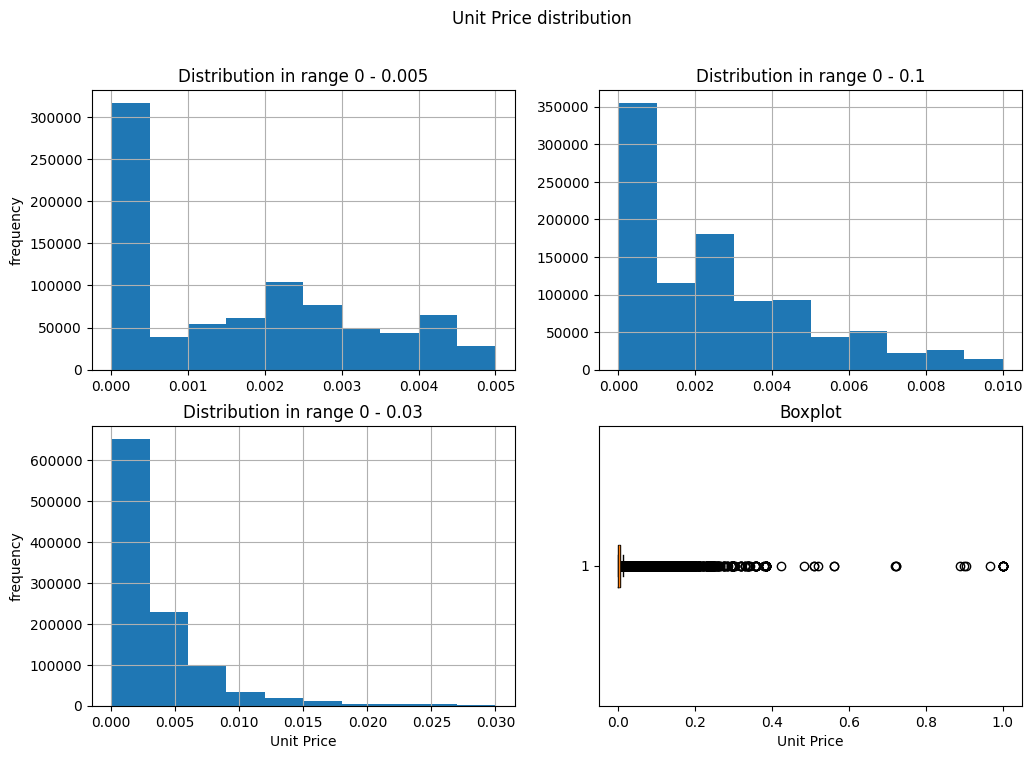

In [632]:
plt.figure(figsize=(12, 8))
plt.suptitle('Unit Price distribution')

plt.subplot(221)
plt.title('Distribution in range 0 - 0.005')
products_sg.unit_price.hist(range=(0, 0.005))
plt.ylabel('frequency')

plt.subplot(222)
plt.title('Distribution in range 0 - 0.1')
products_sg.unit_price.hist(range=(0, 0.01))

plt.subplot(223)
plt.title('Distribution in range 0 - 0.03')
plt.ylabel('frequency')
plt.xlabel('Unit Price')
products_sg.unit_price.hist(range=(0, 0.03))

plt.subplot(224)
plt.title('Boxplot')
plt.xlabel('Unit Price')
plt.boxplot(products_sg['unit_price'], vert=False)

plt.show()

>Так как цена не будет спользоваться в дальшейшей модели коллаборативной фильтрации, то не будем удалять из датасета продектов нудевыые цени и из датасета заказов заказы с продуктами с нулевой ценой.

Однако выбросы справа необходимо отрезать. Построим еще один более крупный боксплот, чтобы оценить границу.

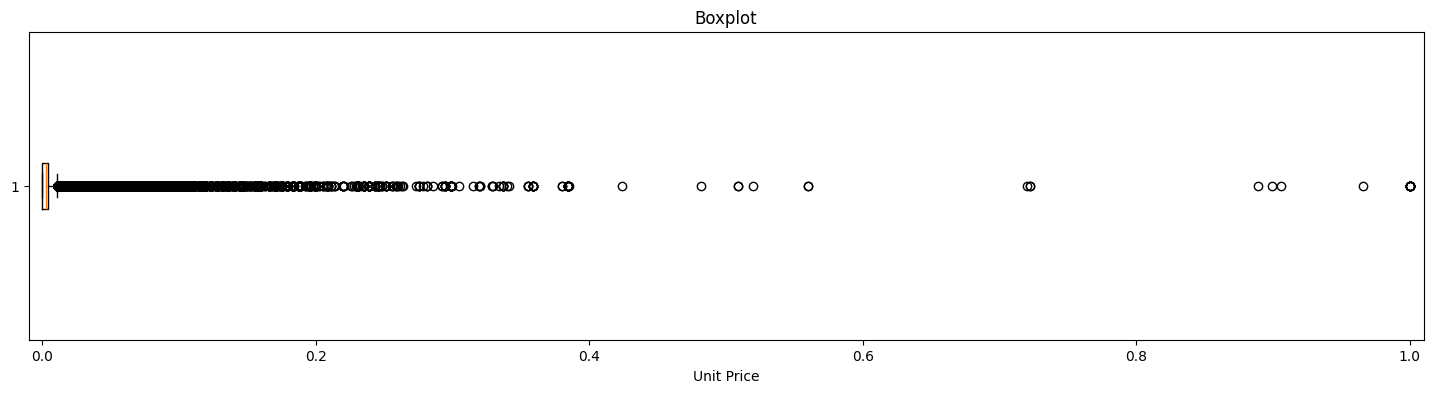

In [633]:
plt.figure(figsize=(18, 4))
plt.title('Boxplot')
plt.xlabel('Unit Price')
plt.boxplot(products_sg['unit_price'], vert=False)
plt.margins(x=0.01)
plt.show();

Спокойно можно обрезать по 0.3

In [634]:
products_sg[products_sg.unit_price <= 0.3].shape[0] / products_sg.shape[0] * 100

99.9938132675415

Обрезая диапазон до 30% мы отрезаем всего лишь одну сотую процента данных.

In [635]:
products_sg[products_sg.unit_price <= 0.03].shape[0] / products_sg.shape[0] * 100

99.1377944673739

Снизим порог цены до 0.03.

In [637]:
products_sg = products_sg[products_sg.unit_price <= 0.03]
products_sg.shape

(1057601, 4)

##### Name

Особенности текстового поля с именем рассмотрим ниже

##### Merge Check

Склеим датасеты, чтобы увидеть более полную картину дублей и соотношения набора продуктов и продуктов в заказах

In [474]:
%%time
merged = orders_sg.merge(products_sg, on=['product_id', 'vendor_id'], how='left')

CPU times: total: 1min 20s
Wall time: 1min 25s


In [475]:
merged.shape

(4023005, 11)

In [476]:
merged.isna().sum()

customer_id       0
geohash           0
order_id          0
vendor_id         0
product_id        0
day_of_week       0
order_time        0
order_day         0
order_day_int     0
name             49
unit_price       49
dtype: int64

Видим что 49 продуктов по паре айди и вендора не присутствуют в заказах.

In [477]:
merged[merged.unit_price.isna()].vendor_id.unique()

array(['a06f1cbf'], dtype=object)

In [478]:
merged[merged.unit_price.isna()].product_id.unique()

array(['1cc4fc0888d2', '5639066e786a', 'e65f47a39650', '6acee6cf16ca',
       '3cfc6048b8eb', '06f435509b10'], dtype=object)

In [479]:
products_sg[products_sg.product_id.isin(merged[merged.unit_price.isna()].product_id)]

,vendor_id,product_id,name,unit_price
213384,4cf81fe1,6acee6cf16ca,I16. Mixed Ingredients Crispy Noodles 什锦滑蛋生面,0.0024
258777,4cf81fe1,3cfc6048b8eb,I15. Mee Goreng 海鲜马来炒面,0.0024
294543,4cf81fe1,e65f47a39650,I13. KL Dai Lok Mee K L 大碌面,0.0028
306263,4cf81fe1,5639066e786a,I14. KL White Loh Mee K L 白卤面,0.0028
431639,4cf81fe1,1cc4fc0888d2,I17. Salted Fish Fried Rice 咸鱼炒饭,0.0024
444594,4cf81fe1,06f435509b10,I18. Fried Dry Hor Fun 干炒河,0.0024


In [480]:
products_sg[products_sg.vendor_id.isin(merged[merged.unit_price.isna()].vendor_id) \
            & products_sg.product_id.isin(merged[merged.unit_price.isna()].product_id)]

,vendor_id,product_id,name,unit_price


Видим, что с продуктами в целом нет ничего подозрительного, просто датасет продуктов сожержит большее количество продуктов чем продавалось в рассматриваемый период, однако важно заметить что продукты '1cc4fc0888d2', '5639066e786a', 'e65f47a39650', '6acee6cf16ca', '3cfc6048b8eb', '06f435509b10' продаваемые вендором 'a06f1cbf' есть в датасете продаж, но их нет в датасете продуктов

In [481]:
# здесь у всех без сэмпла вендор a06f1cbf
merged[merged.name.isna()].sample(10)

,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day,order_day_int,name,unit_price
1945652,7f07f12e54,w21zt,952779,a06f1cbf,3cfc6048b8eb,0,14:53:33,15 days,15,NaN,NaN
488193,2c1a7f957b,w21zt,237745,a06f1cbf,e65f47a39650,6,19:34:53,7 days,7,NaN,NaN
748552,99f855a7bb,w21zt,364449,a06f1cbf,e65f47a39650,5,11:51:09,55 days,55,NaN,NaN
1784125,0077b691ca,w21zv,870420,a06f1cbf,3cfc6048b8eb,5,17:39:53,34 days,34,NaN,NaN
263159,dd14d6efaf,w21zt,128011,a06f1cbf,1cc4fc0888d2,4,13:25:55,47 days,47,NaN,NaN
1256675,49f768a5c8,w21zt,612810,a06f1cbf,1cc4fc0888d2,5,17:55:59,55 days,55,NaN,NaN
2264510,08c68e7555,w21zt,1115540,a06f1cbf,6acee6cf16ca,1,19:44:09,44 days,44,NaN,NaN
165193,b287a31618,w21zv,80911,a06f1cbf,6acee6cf16ca,0,11:55:23,8 days,8,NaN,NaN
2157977,f660fa84b0,w21zt,1061165,a06f1cbf,e65f47a39650,6,17:27:12,77 days,77,NaN,NaN
2813869,e4d5c263d8,w21zt,1397064,a06f1cbf,e65f47a39650,2,21:25:16,80 days,80,NaN,NaN


In [482]:
orders_sg[orders_sg.vendor_id == 'a06f1cbf'].shape

(308, 9)

In [483]:
merged[(merged.vendor_id == 'a06f1cbf') & (merged.name.notna())].shape

(259, 11)

In [484]:
merged[(merged.product_id == '6acee6cf16ca')]

,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day,order_day_int,name,unit_price
165193,b287a31618,w21zv,80911,a06f1cbf,6acee6cf16ca,0,11:55:23,8 days,8,NaN,NaN
313149,bd8f89ca53,w21zt,152160,a06f1cbf,6acee6cf16ca,1,18:04:00,23 days,23,NaN,NaN
1660729,cb662ac16d,w21zt,809267,a06f1cbf,6acee6cf16ca,6,19:43:59,7 days,7,NaN,NaN
2157976,f660fa84b0,w21zt,1061164,a06f1cbf,6acee6cf16ca,5,18:59:37,41 days,41,NaN,NaN
2157978,f660fa84b0,w21zt,1061165,a06f1cbf,6acee6cf16ca,6,17:27:12,77 days,77,NaN,NaN
2264510,08c68e7555,w21zt,1115540,a06f1cbf,6acee6cf16ca,1,19:44:09,44 days,44,NaN,NaN
2573603,1c20106051,w21zt,1274572,a06f1cbf,6acee6cf16ca,0,19:19:12,15 days,15,NaN,NaN
2603192,f63289b389,w21zt,1289524,a06f1cbf,6acee6cf16ca,1,18:38:43,2 days,2,NaN,NaN
3765539,3aac7e0ac4,w21zt,1874564,a06f1cbf,6acee6cf16ca,6,17:35:27,77 days,77,NaN,NaN


Можно заметить, что указанные продукты имеются в датасете заказов, но с другим вендором, что приводит к выводу, что у продукта сменился вендор, а данные в датасете продуктов не обновили. Заменим в датасете взаимодействий вендора на актуального на момент заказа, чтобы не терять заказы.

In [485]:
products_sg[(products_sg.product_id.isin(merged[merged.name.isna()].product_id.unique()))]

,vendor_id,product_id,name,unit_price
213384,4cf81fe1,6acee6cf16ca,I16. Mixed Ingredients Crispy Noodles 什锦滑蛋生面,0.0024
258777,4cf81fe1,3cfc6048b8eb,I15. Mee Goreng 海鲜马来炒面,0.0024
294543,4cf81fe1,e65f47a39650,I13. KL Dai Lok Mee K L 大碌面,0.0028
306263,4cf81fe1,5639066e786a,I14. KL White Loh Mee K L 白卤面,0.0028
431639,4cf81fe1,1cc4fc0888d2,I17. Salted Fish Fried Rice 咸鱼炒饭,0.0024
444594,4cf81fe1,06f435509b10,I18. Fried Dry Hor Fun 干炒河,0.0024


Видим что актуальный вендор это 4cf81fe1

In [486]:
# можно было предположить что у эти вендоры принадлежат к одной сети, но нет
vendors_sg[vendors_sg.vendor_id.isin(['a06f1cbf', '4cf81fe1'])]

,vendor_id,chain_id,geohash,primary_cuisine
Unnamed: 0,,,,
6988,4cf81fe1,nan,w21xr,chinese
7503,a06f1cbf,f24465fd,w21zt,chinese


In [487]:
orders_sg.loc[(orders_sg.vendor_id == 'a06f1cbf') & 
              (orders_sg.product_id.isin(merged[merged.name.isna()].product_id.unique())), 'vendor_id'] = '4cf81fe1'

In [488]:
# перемердживаем измененные датасеты
merged = orders_sg.merge(products_sg, on=['product_id', 'vendor_id'], how='left')

In [489]:
merged.shape

(4023005, 11)

In [490]:
merged.isna().sum()

customer_id      0
geohash          0
order_id         0
vendor_id        0
product_id       0
day_of_week      0
order_time       0
order_day        0
order_day_int    0
name             0
unit_price       0
dtype: int64

In [491]:
merged.nunique()

customer_id       512916
geohash               45
order_id         2000000
vendor_id           7411
product_id        256502
day_of_week            7
order_time         82013
order_day             91
order_day_int         91
name               99591
unit_price           185
dtype: int64

In [492]:
# чисто ради интереса посчитаем среднее количество заказов од одного покупателя за эти 90 дней
merged.order_id.nunique() / merged.customer_id.nunique()

3.899273955189544

#### Check Vendors DS

In [493]:
vendors_sg.vendor_id.nunique()

7411

In [494]:
products_sg.vendor_id.nunique()

7411

In [495]:
orders_sg.vendor_id.nunique()

7411

In [496]:
set(orders_sg.vendor_id) == set(vendors_sg.vendor_id) == set(products_sg.vendor_id)

True

Все вендоры из датасета вендоров представлены в заказах

In [497]:
vendors_sg

,vendor_id,chain_id,geohash,primary_cuisine
Unnamed: 0,,,,
0,b160c319,d2786168,w21z6,mexican
1,9c8f010e,d2786168,w21ze,mexican
4,03eb25e1,5055ab25,w21ze,bak kut teh
5,3613129a,8984acb6,w23b1,italian
7,0946c9e5,1e3a2913,w21z4,bak kut teh
...,...,...,...,...
17798,2d0b2dfb,1a3564c8,w21zt,mala xiang guo
17799,15bbf316,434020fb,w21zs,mala xiang guo
17801,a1f11221,b5431702,w21zu,mala xiang guo


In [498]:
vendors_sg.duplicated(['vendor_id']).sum()

0

In [499]:
vendors_sg.duplicated(['vendor_id', 'geohash']).sum()

0

Интересно, что означает хэш в датасете с вендорами?

In [500]:
print(len(set(vendors_sg.geohash)), len(set(orders_sg.geohash)))

31 45


In [501]:
len(set(vendors_sg.geohash) & set(orders_sg.geohash))

31

In [502]:
set(vendors_sg.geohash) - set(orders_sg.geohash)

set()

In [503]:
set(orders_sg.geohash) - set(vendors_sg.geohash) 

{'w21xj',
 'w21xm',
 'w21xn',
 'w21xp',
 'w21xq',
 'w21xw',
 'w21xz',
 'w21z1',
 'w21zq',
 'w21zr',
 'w21zx',
 'w21zz',
 'w238p',
 'w23b7'}

Множество геохэшей датасета вендоров является подмножеством множества геохэшей датасета продаж
Получается, если геохэш вендора означает местоположение вендора, то все вендоры находятся примерно в той же области, откуда происходят заказы.

In [504]:
vendors_sg[['geohash', 'vendor_id']].value_counts(dropna=False)

geohash  vendor_id
w21xr    4cf81fe1     1
w21zk    2b992a15     1
         29e1b765     1
         28f5bafd     1
         28a35710     1
                     ..
w21z7    ba373d26     1
         ba2329fa     1
         ba15b5c2     1
         b9de26c6     1
w23bh    fe4cf855     1
Name: count, Length: 7411, dtype: int64

In [505]:
orders_sg.geohash.nunique()

45

In [506]:
check = orders_sg[['vendor_id', 'geohash']].merge(vendors_sg[['vendor_id', 'geohash']], on='vendor_id', how='left')
check[check.geohash_x != check.geohash_y]

,vendor_id,geohash_x,geohash_y
13,ee4f2ee0,w21z6,w21z7
14,ee4f2ee0,w21z6,w21z7
15,ee4f2ee0,w21z6,w21z7
16,ee4f2ee0,w21z6,w21z7
17,b62d39b7,w21z6,w21z3
...,...,...,...
4023000,ff0edd9f,w21zt,w21zv
4023001,ff0edd9f,w21zt,w21zv
4023002,2bba6450,w21zt,w21zv
4023003,2bba6450,w21zt,w21zv


Выше мы видим множество вендоров, товары которых доставлялись вне гексагона присутствия вендора.

~1. интересно что у каждого взаимодействия (заказа) есть только 1 вендор~
~2. для каждого вендора в заказах есть несколько разных геохэшей~

Какой же выбран геохэш для вендора в датасете вендоров - не ясно точно :( рандомный из датасета заказов?
Остановимся на том, что он имеет значение местонахождения вендора

#### Merged DS

Для более полного пониамния дубликатов соберем всю информацию из 3 датасетов воедино

In [510]:
merged2 = merged.merge(vendors_sg, how='left', on='vendor_id').rename(columns={'geohash_x': 'geohash_order', 'geohash_y': 'geohash_vendor'})
merged2.shape

(4023005, 14)

In [512]:
merged2[merged2.duplicated(keep='first')].shape

(99521, 14)

In [513]:
merged2.columns

Index(['customer_id', 'geohash_order', 'order_id', 'vendor_id', 'product_id',
       'day_of_week', 'order_time', 'order_day', 'order_day_int', 'name',
       'unit_price', 'chain_id', 'geohash_vendor', 'primary_cuisine'],
      dtype='object')

In [519]:
# % дублей в датасете заказов
f' % дублей в датасете заказов {merged2[merged2.duplicated()].shape[0] / merged2.shape[0] * 100 :.2f} %'

' % дублей в датасете заказов 2.47 %'

In [517]:
merged2.duplicated(keep=False).sum()

187377

In [523]:
merged2[['customer_id', 'geohash_order', 'order_id', 'vendor_id', 'product_id',
       'day_of_week', 'order_time', 'order_day', 'order_day_int', 'name',
       'primary_cuisine']].duplicated(keep=False).sum()

187377

Посмотрим на агрегацию дублей по количеству. Если максимальное количество не превышает разумное одинаковых количество товаров в корзине, то дропнем их

In [202]:
# dupl_products = pd.DataFrame(merged2[merged2.duplicated(keep=False)].groupby(['customer_id', 'geohash_order', 'order_id', 'vendor_id', 
#                  'product_id', 'day_of_week', 'order_time', 'order_day', 
#                  'order_day_int', 'name', 'unit_price', 'chain_id', 
#                  'geohash_vendor', 'primary_cuisine']).agg('size'))

In [305]:
dupl_interactions = (
              merged2[merged2.duplicated(keep=False)].groupby(merged2[merged2.duplicated(keep=False)].columns.tolist())
              .size()
              .reset_index()
              .rename(columns = {0: 'count'})
            )

In [306]:
dupl_interactions['count'].sum()

187377

In [321]:
dupl_interactions['count'].value_counts(dropna=False)

count
2     78557
3      7598
4      1292
5       269
6        78
7        37
8        12
9         8
11        3
13        1
15        1
Name: count, dtype: int64

Количество штук до 10 не вызывает вопросов совсем, больше 10 - посмотрим что это за товары

In [346]:
dupl_interactions[dupl_interactions['count'] > 10]

,customer_id,geohash_order,order_id,vendor_id,product_id,day_of_week,order_time,order_day,order_day_int,name,unit_price,chain_id,geohash_vendor,primary_cuisine,count
6699,1387f1c488,w21z7,1498189,a36b7d7a,b31d6c9d1966,2,18:42:37,80 days,80,Ala Carte,0.0032,94fcafef,w21z7,healthy,13
32743,6013608afc,w21ze,1072442,020439a9,29a7bbfc44e0,1,13:43:04,37 days,37,Yakitori Stick,0.0000,dfdc19d5,w21z7,japanese,11
36493,6acf997ae3,w21zs,750996,7e2d81c2,caf014dd125c,6,16:44:01,21 days,21,Single Regular Scoop,0.0028,8b17f4e6,w21zs,dessert,11
39754,74a787a7da,w21ze,1026590,020439a9,564c3583680c,1,14:41:21,37 days,37,Customized Bento,0.0000,dfdc19d5,w21z7,japanese,15
47229,8a56755689,w21z8,1087361,fb606a7d,74d4a9ac4768,5,20:05:37,6 days,6,Spicy 中辣,0.0000,b2264498,w21z8,mala xiang guo,11


In [324]:
translator.translate("中辣")

'Midspicy'

Это палочки и единичные скупы, Ala Carte тоже предполагает единичное блюдо - нормально, что их брали по многу штук. и что-то острое среднеострое :) В целом считаем, что можно сбросить дубли

In [326]:
# Сбросим полные дубли
merged2 = merged2.drop_duplicates()

In [327]:
merged2.shape

(3923484, 14)

Для проверки сравниваем с количествами уникальных значений сырых данных, убеждаемся, что ничего не потеряли

In [328]:
merged2.nunique()

customer_id         512916
geohash_order           45
order_id           2000000
vendor_id             7411
product_id          256502
day_of_week              7
order_time           82013
order_day               91
order_day_int           91
name                 99591
unit_price             185
chain_id              1855
geohash_vendor          31
primary_cuisine         78
dtype: int64

##### geohashes

In [ ]:
def calculate_distance(row) -> float:
    '''Calculate distance from customer to vendor.
    
    Args:
    - row - row of dataframe during df.apply(calculate_distance, axis=1)
    '''
    
    user_geo = row['geohash']
    vendor_geo = row['geohash_vendor']
    
    if user_geo == vendor_geo:
        return 0.0
    else:
        convert_to_float = lambda x: [float(coord) for coord in geohash2.decode(x)]
        
        x1_y1 = convert_to_float(user_geo)
        x2_y2 = convert_to_float(vendor_geo)
        
        return round(((x2_y2[0] - x1_y1[0]) ** 2 + (x2_y2[1] - x1_y1[1]) ** 2) ** 0.5, 1)

#### Make Groupped Orders DS

In [356]:
%%time
# agg_func_count = {'product_id': ['count', 'nunique', 'size']}
# agg_func_text = {'vendor_id': ['count', 'nunique', set], 
#                  'product_id': ['count', 'nunique', set],
#                  'order_day': [set],
#                  'day_of_week': [set], 
#                  'order_time': [set],
#                  'name': [set], 
#                  'geohash_order': [set], 
#                  'primary_cuisine': [set, 'count', 'nunique']}
# group = merged2.groupby('order_id').agg(agg_func_text)
# group.to_pickle('data/groupped_orders')

CPU times: total: 12min 7s
Wall time: 12min 30s


In [ ]:
# group = pd.read_pickle('data/groupped_orders')

In [360]:
group

vendor_id                     product_id          \
             count nunique         set      count nunique   
order_id                                                    
0                5       1  {212753d2}          5       5   
1                8       1  {21830106}          8       8   
2                4       1  {ee4f2ee0}          4       4   
3                3       1  {b62d39b7}          3       3   
4                4       1  {e33ad7ec}          4       4   
...            ...     ...         ...        ...     ...   
1999995          1       1  {2dbc05bb}          1       1   
1999996          2       1  {43bd9cf3}          2       2   
1999997          3       1  {81960769}          3       3   
1999998          2       1  {ff0edd9f}          2       2   
1999999          3       1  {2bba6450}          3       3   

                                                             order_day  \
                                                        set        set   
order_id                                                                 
0         {783e85338f1c, 084ab73246e6, 20049fb602cb, 391...  {85 days}   
1         {64a268be5f2e, 01110c80a0fa, f245bdf79350, 528...  {61 days}   
2         {2c349859aa69, a3e4aac0520d, 4e1d649b81a5, b47...   {8 days}   
3                {ad485fc36ebe, d732733afc92, 60a5baff060c}  {59 days}   
4         {ff6a45fa52e6, 5bb2e3772724, cbe8ace5c352, bc5...  {81 days}   
...                                                     ...        ...   
1999995                                      {cad0a6aa5b51}  {32 days}   
1999996                        {142ad3401af3, 6b36ca15e1f6}   {4 days}   
1999997          {e418a2a168d8, 3707116ae849, 75ff2fb5b5ef}  {28 days}   
1999998                        {7602ccd87eea, 91129b65ae92}  {55 days}   
1999999          {7bb67a5dd524, d40fe2db522c, 5925157ecb14}  {62 days}   

         day_of_week  order_time  \
                 set         set   
order_id                           
0                {0}  {12:03:29}   
1                {4}  {19:03:03}   
2                {0}  {18:08:42}   
3                {2}  {19:05:15}   
4                {3}  {20:13:08}   
...              ...         ...   
1999995          {3}  {16:21:22}   
1999996          {3}  {15:57:51}   
1999997          {6}  {10:27:34}   
1999998          {5}  {22:09:10}   
1999999          {5}  {19:57:51}   

                                                       name geohash_order  \
                                                        set           set   
order_id                                                                    
0         {209. Japanese Beef Yakiniku Don, 206. Beef Su...       {w21z7}   
1         {Chicken Cutlet with Rice, Tomato Sauce Spaghe...       {w21zt}   
2         {V12. Summer Rolls, V7. Beef Noodle Soup, V15....       {w21z6}   
3          {Linguine Al Granchio, Diavola, Cinque Formaggi}       {w21z6}   
4         {Bruschetta, House Salad, Valrhona Choc Cake, ...       {w21z6}   
...                                                     ...           ...   
1999995   {Buddy Meal A: 2 X Nasi Lemak + Bergedil + 2 D...       {w21zt}   
1999996   {D10) Crispy Chicken Roll, R24) Nasi Goreng Ka...       {w21zt}   
1999997                {Curry Puff, Tuna Puff, Chicken Pie}       {w21zt}   
1999998   {Laksa Prawn Spaghetti, Smoked Duck Penne with...       {w21zt}   
1999999   {Beef, Tom Yam Fried Rice, A27 Salted Egg Chic...       {w21zt}   

         primary_cuisine  
                     set  
order_id                  
0                {ramen}  
1              {western}  
2           {vietnamese}  
3                {pizza}  
4                {pasta}  
...                  ...  
1999995     {nasi lemak}  
1999996    {singaporean}  
1999997          {cakes}  
1999998          {pasta}  
1999999     {fried rice}  

[2000000 rows x 12 columns]

In [411]:
print(all(group[('product_id', 'nunique')] == group[('product_id', 'count')]))
print(all(group[('vendor_id', 'nunique')] == 1))
print(all(group[('vendor_id', 'nunique')] == group[('vendor_id', 'count')]))
print('\n')
print(all(group['name', 'set'].str.len() == 1))
print(any(group['name', 'set'].str.len() == 1))
print(any(group['name', 'set'].str.len() == 0))
print('\n')
print(all(group['geohash_order', 'set'].str.len() == 1))
print(all(group['primary_cuisine', 'set'].str.len() == 1))
print(all(group['order_time', 'set'].str.len() == 1))
print(all(group['day_of_week', 'set'].str.len() == 1))

True
False
False


False
True
False


True
True
True
True


- в одном заказе всегда только разные товары (тк мы удалили дубли)
- в одном заказе не всегда только 1 вендор и бывают дублирующиеся вендоры, что ок
- в одном заказе товары с разными названиями
- одному заказу всегда соответствует 1 хэш, 1 тип кухни, 1 день и 1 время - тут все логично, кроме типа кухни

если у заказа бывает несколько вендоров, а у каждого вендора своя кухня, то было бы логично, чтобы внутри одного заказа иногда попадались разные кухни

In [423]:
groupped_orders = group[[('vendor_id', 'set'), 
                         ('product_id', 'set'), 
                         ('order_day', 'set'), 
                         ('day_of_week', 'set'), 
                         ('geohash_order', 'set'),
                         ('order_time', 'set'),
                         ('name', 'set'),
                         ('primary_cuisine', 'set')]].copy(deep=True)

groupped_orders.columns = groupped_orders.columns.droplevel(-1)

In [424]:
groupped_orders

,vendor_id,product_id,order_day,day_of_week,geohash_order,order_time,name,primary_cuisine
order_id,,,,,,,,
0,{212753d2},"{783e85338f1c, 084ab73246e6, 20049fb602cb, 391...",{85 days},{0},{w21z7},{12:03:29},"{209. Japanese Beef Yakiniku Don, 206. Beef Su...",{ramen}
1,{21830106},"{64a268be5f2e, 01110c80a0fa, f245bdf79350, 528...",{61 days},{4},{w21zt},{19:03:03},"{Chicken Cutlet with Rice, Tomato Sauce Spaghe...",{western}
2,{ee4f2ee0},"{2c349859aa69, a3e4aac0520d, 4e1d649b81a5, b47...",{8 days},{0},{w21z6},{18:08:42},"{V12. Summer Rolls, V7. Beef Noodle Soup, V15....",{vietnamese}
3,{b62d39b7},"{ad485fc36ebe, d732733afc92, 60a5baff060c}",{59 days},{2},{w21z6},{19:05:15},"{Linguine Al Granchio, Diavola, Cinque Formaggi}",{pizza}
4,{e33ad7ec},"{ff6a45fa52e6, 5bb2e3772724, cbe8ace5c352, bc5...",{81 days},{3},{w21z6},{20:13:08},"{Bruschetta, House Salad, Valrhona Choc Cake, ...",{pasta}
...,...,...,...,...,...,...,...,...
1999995,{2dbc05bb},{cad0a6aa5b51},{32 days},{3},{w21zt},{16:21:22},{Buddy Meal A: 2 X Nasi Lemak + Bergedil + 2 D...,{nasi lemak}
1999996,{43bd9cf3},"{142ad3401af3, 6b36ca15e1f6}",{4 days},{3},{w21zt},{15:57:51},"{D10) Crispy Chicken Roll, R24) Nasi Goreng Ka...",{singaporean}
1999997,{81960769},"{e418a2a168d8, 3707116ae849, 75ff2fb5b5ef}",{28 days},{6},{w21zt},{10:27:34},"{Curry Puff, Tuna Puff, Chicken Pie}",{cakes}


In [425]:
# de-set data
groupped_orders[['order_day', 'day_of_week', 'order_time', 'primary_cuisine', 'geohash_order']] = \
groupped_orders[['order_day', 'day_of_week', 'order_time', 'primary_cuisine', 'geohash_order']].explode(['order_day', 'day_of_week', 
                                                                                                                             'order_time', 'primary_cuisine', 
                                                                                                                             'geohash_order'])

In [426]:
groupped_orders['product_id'] = groupped_orders['product_id'].parallel_apply(lambda x: list(x))
groupped_orders['vendor_id'] = groupped_orders['vendor_id'].parallel_apply(lambda x: list(x))
groupped_orders['name'] = groupped_orders['name'].parallel_apply(lambda x: list(x))

In [427]:
groupped_orders = groupped_orders.reset_index()

In [428]:
# groupped_orders.to_pickle('data/groupped_orders_proc')

In [429]:
groupped_orders

,order_id,vendor_id,product_id,order_day,day_of_week,geohash_order,order_time,name,primary_cuisine
0,0,[212753d2],"[30eba3cc2676, 783e85338f1c, 20049fb602cb, 391...",85 days,0,w21z7,12:03:29,"[201. Japanese Garlic Karaage Don, 210. Teriya...",ramen
1,1,[21830106],"[adf53ab3befe, f245bdf79350, 5289a6f50a7b, 6c1...",61 days,4,w21zt,19:03:03,"[Fish & Chips, Chicken Wings with Rice, Grille...",western
2,2,[ee4f2ee0],"[b47b2a83502a, a3e4aac0520d, 4e1d649b81a5, 2c3...",8 days,0,w21z6,18:08:42,"[V15. Vietnamese Pork Belly, V13. Spring Rolls...",vietnamese
3,3,[b62d39b7],"[ad485fc36ebe, d732733afc92, 60a5baff060c]",59 days,2,w21z6,19:05:15,"[Diavola, Cinque Formaggi, Linguine Al Granchio]",pizza
4,4,[e33ad7ec],"[bc5f3e4a7234, ff6a45fa52e6, cbe8ace5c352, 5bb...",81 days,3,w21z6,20:13:08,"[Bruschetta, House Salad, Da Paolo Dolcetto, V...",pasta
...,...,...,...,...,...,...,...,...,...
1999995,1999995,[2dbc05bb],[cad0a6aa5b51],32 days,3,w21zt,16:21:22,[Buddy Meal A: 2 X Nasi Lemak + Bergedil + 2 D...,nasi lemak
1999996,1999996,[43bd9cf3],"[6b36ca15e1f6, 142ad3401af3]",4 days,3,w21zt,15:57:51,"[R24) Nasi Goreng Kampung, D10) Crispy Chicken...",singaporean
1999997,1999997,[81960769],"[e418a2a168d8, 3707116ae849, 75ff2fb5b5ef]",28 days,6,w21zt,10:27:34,"[Tuna Puff, Chicken Pie, Curry Puff]",cakes
1999998,1999998,[ff0edd9f],"[91129b65ae92, 7602ccd87eea]",55 days,5,w21zt,22:09:10,"[Laksa Prawn Spaghetti, Smoked Duck Penne with...",pasta


In [430]:
groupped_orders.duplicated(['order_id']).sum()

0

In [432]:
groupped_orders.duplicated(['order_id', 'geohash_order']).sum()

0

С заказами верхнеуровнево все ок.

**Доп исследование истории заказов**

In [96]:
groupped_orders.product_id.explode().value_counts()

product_id
b571418f4bdd    618
d3be540e4f36    612
2f57ce86ab5d    598
ecc84756562d    592
17b9099311ee    586
               ... 
e9f722ab3b88      1
19c07d79cd6b      1
f0c5f1fd2799      1
6b27a0998ad1      1
a284a6f269f8      1
Name: count, Length: 256502, dtype: int64

Для построения моделей может иметь смысл удаление из датасета самых часто и редко встречающихся товаров

In [ ]:
for i in groupped_orders.iterrows():
    i.product_id

## Visual Analysis

#### Prices

посмотрим еще дополнительно на цены

In [329]:
products_sg[products_sg.unit_price == 0].shape

(294502, 4)

In [191]:
products_sg[products_sg.unit_price == 0].product_id.nunique()

294542

In [194]:
orders_sg[orders_sg.product_id.isin(products_sg[products_sg.unit_price == 0].product_id.unique())].shape

(40462, 9)

In [196]:
orders_sg.shape

(4023005, 9)

In [197]:
orders_sg_cut = orders_sg[~orders_sg.product_id.isin(products_sg[products_sg.unit_price == 0].product_id.unique())]

In [198]:
orders_sg_cut.shape

(3982543, 9)

агрегируем и посмотрим на распределение времени заказа

In [216]:
products_sg.shape

(1066838, 4)

In [230]:
products_sg[products_sg.unit_price > 0.02]

,vendor_id,product_id,name,unit_price
29,3c1d4c4f,a102e5175176,Re Focus Hard,0.0516
30,3c1d4c4f,a2f31ddc1d30,Re Wind Soft,0.0468
85,2f2bcb7c,d30bdb10ff22,Galaxy Durian MSW - 7 Inch,0.0356
127,c84ac95c,ace052fe45fa,BBQ Set A,0.0276
128,c84ac95c,69d226a6bd39,BBQ Set B,0.0276
...,...,...,...,...
962021,f349812f,4a641f0ef2ea,Twinpack Quart - 2 x Quart,0.0216
962047,e89fb82f,86f6db5264c2,Full,0.0220
962059,af827e5c,04c16331f695,Jumbo Prawn & Rosu Katsu Set,0.0236
962070,d6333098,b04fbe8974ab,Pork Belly Chashu (Frozen),0.0208


In [241]:
products_sg[(products_sg.unit_price != 0) & (products_sg.unit_price < 0.01)].shape

(693725, 4)

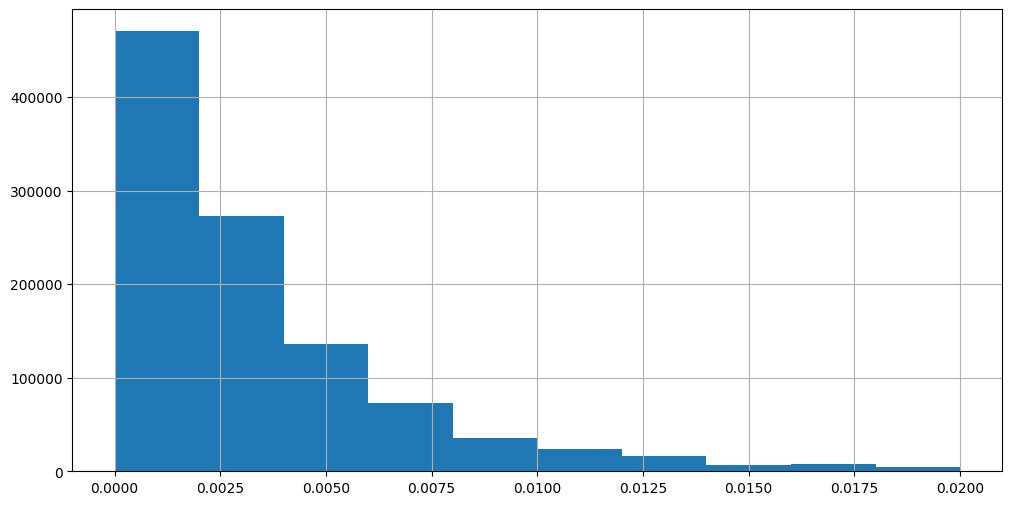

In [234]:
plt.figure(figsize=(12, 6))

products_sg.unit_price.hist(range=(0, 0.02))
plt.show()

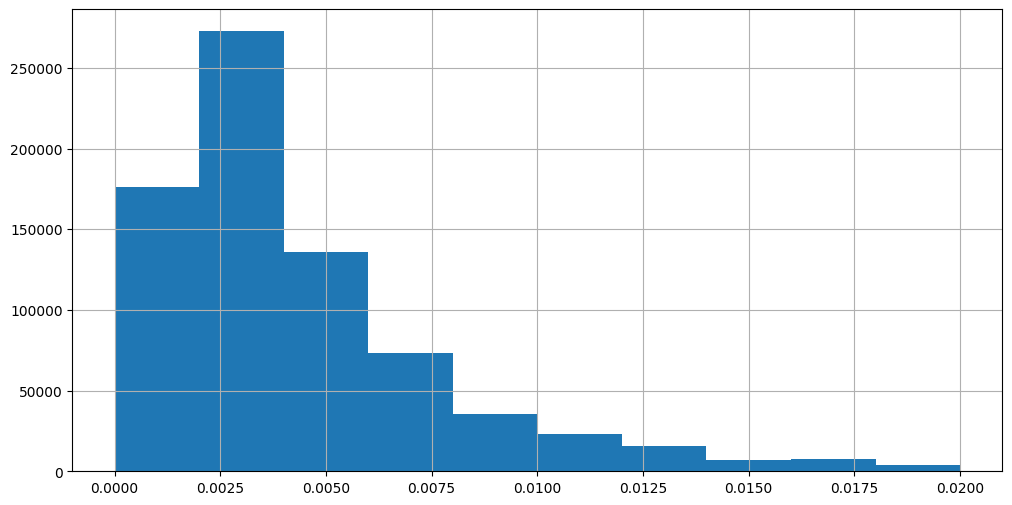

In [235]:
plt.figure(figsize=(12, 6))

products_sg[products_sg.unit_price != 0].unit_price.hist(range=(0, 0.02))
plt.show()

Во-первых нам не нужны продукты с ценой 0
Во-вторых нужно хоть немного укоротить хвост распределения и выкинуть продукты с ценой больше 0.02

In [244]:
orders_sg_cut['order_hour'] = orders_sg_cut['order_time'].parallel_apply(lambda x: int(x.split(':')[0]))

C:\Users\User\AppData\Local\Temp\ipykernel_18712\1052680767.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_sg_cut['order_hour'] = orders_sg_cut['order_time'].parallel_apply(lambda x: int(x.split(':')[0]))


<Axes: xlabel='order_hour'>

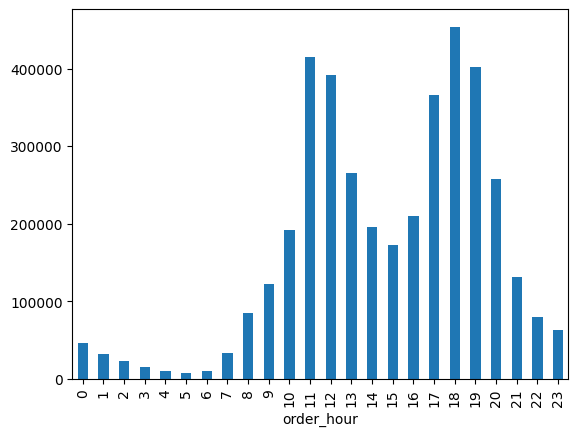

In [245]:
orders_sg_cut['order_hour'].value_counts().loc[[0, 1, 2, 3,
                                            4, 5, 6, 7,
                                            8, 9, 10, 11,
                                            12, 13, 14, 15,
                                            16, 17, 18, 19,
                                            20, 21, 22, 23]].plot.bar()

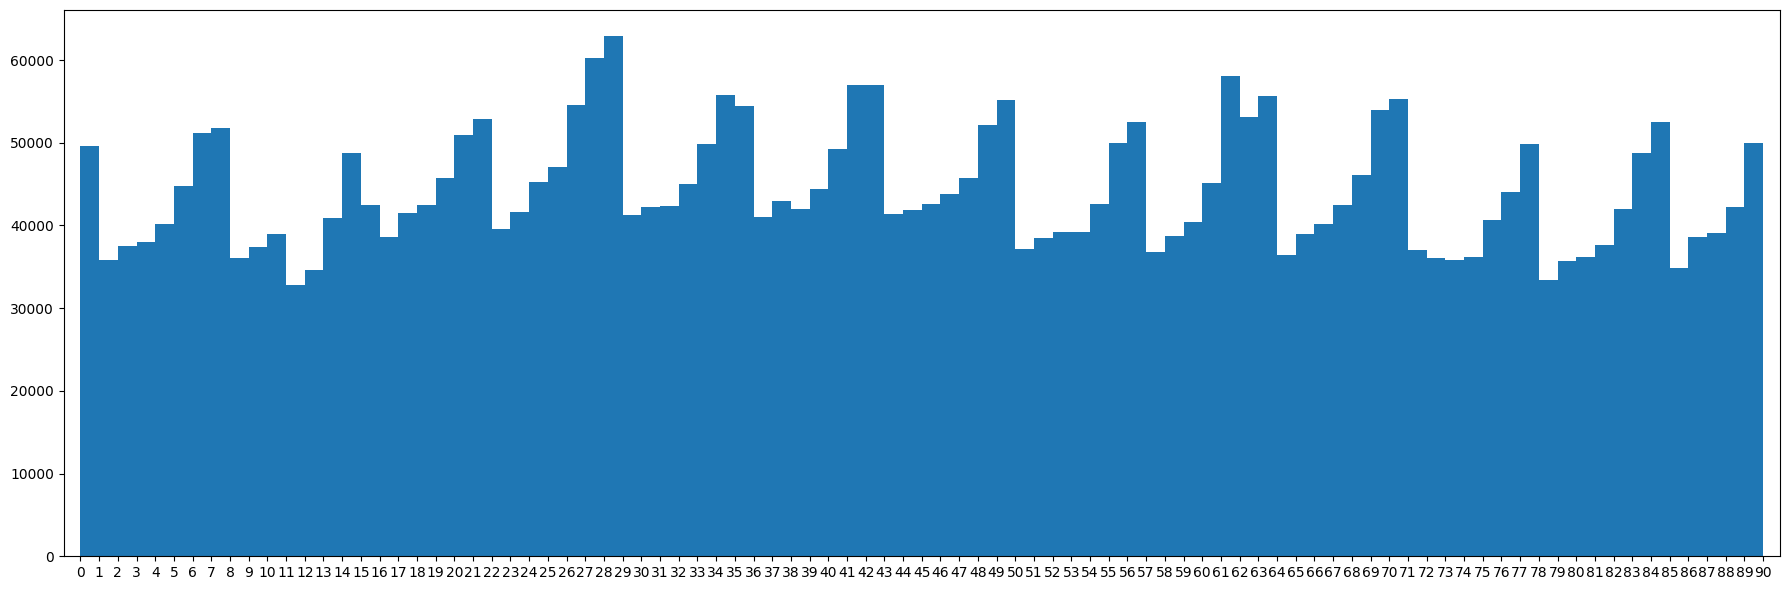

In [246]:
# orders_sg['order_day_int'].value_counts().plot.bar()
plt.figure(figsize=(18, 6))
plt.hist(orders_sg_cut['order_day_int'], bins=90)
plt.xticks(orders_sg_cut['order_day_int'].unique())
plt.tight_layout()
plt.margins(x=0.01)
plt.show();

Возьмем последние 50 дней чтобы использовать более актуальные заказы

<Axes: >

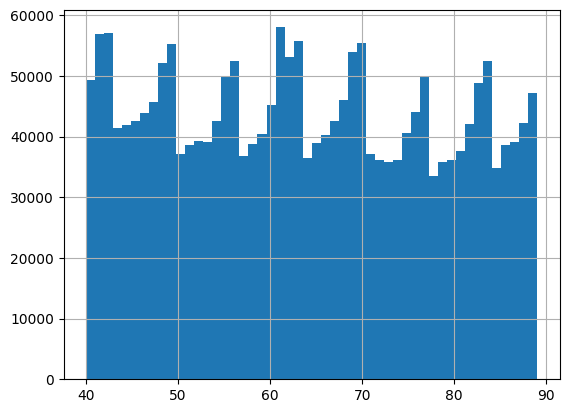

In [268]:
orders_sg_cut[(orders_sg_cut.order_day_int > 39) & (orders_sg_cut.order_day_int < 90)]['order_day_int'].hist(bins=50)

<Axes: >

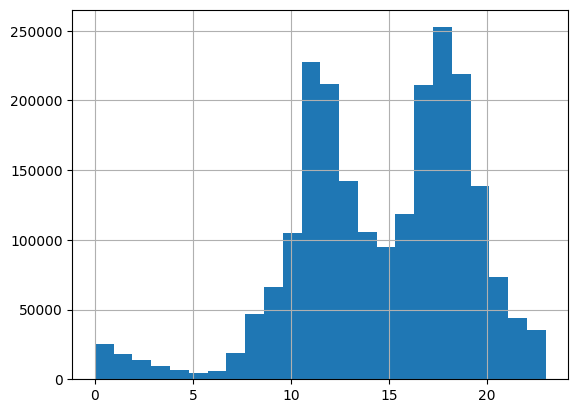

In [269]:
orders_sg_cut[(orders_sg_cut.order_day_int > 39) & (orders_sg_cut.order_day_int < 90)]['order_hour'].hist(bins=24)

<Axes: >

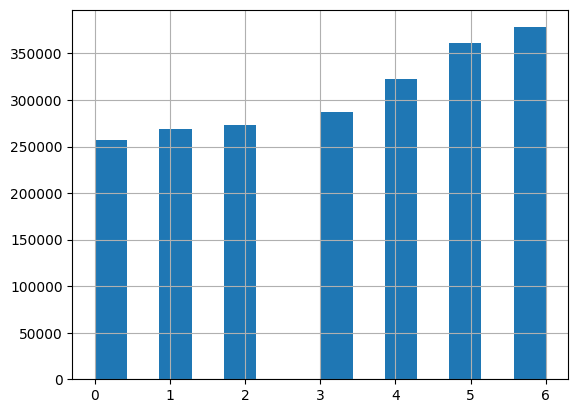

In [270]:
orders_sg_cut[orders_sg_cut.order_day_int > 40]['day_of_week'].hist(bins=14)

In [247]:
# def make_date(ds):
#   # print(ds['order_day'])
#   return pd.to_datetime(
#     str(pd.to_datetime('03/06/2023', format='%d/%m/%Y') + pd.to_timedelta(ds['order_day']))[:10] + ' ' + ds['order_time'],
#     format='%Y-%m-%d %H:%M:%S')

# orders_sg['order_time_dt'] = orders_sg[['order_day', 'order_time']].parallel_apply(make_date, axis=1)

In [249]:
# orders_sg['order_time_dt'] =
# pd.Timestamp.today().date() - pd.to_timedelta('92 days')

# datetime.datetime.now().date()  - pd.to_timedelta('55 days')

In [248]:
# orders_sg['order_time_dt'] = pd.to_datetime(orders_sg.order_time, format='%H:%M:%S').dt.time

## Correlation Analysis

In [282]:
from sklearn.preprocessing import LabelEncoder

In [271]:
orders_sg_cut.columns

Index(['customer_id', 'geohash', 'order_id', 'vendor_id', 'product_id',
       'day_of_week', 'order_time', 'order_day', 'order_day_int',
       'order_hour'],
      dtype='object')

In [277]:
# pd.set_option("precision", 3)
correlation=orders_sg_cut[['order_id', 'day_of_week', 'order_day_int', 'order_hour']].corr(method='pearson')
correlation

,order_id,day_of_week,order_day_int,order_hour
order_id,1.000000,-0.003764,0.002097,0.005853
day_of_week,-0.003764,1.000000,0.008112,-0.000265
order_day_int,0.002097,0.008112,1.000000,-0.003101
order_hour,0.005853,-0.000265,-0.003101,1.000000


In [279]:
products_sg_cut = products_sg[products_sg.unit_price != 0]

In [280]:
products_sg_cut.columns

Index(['vendor_id', 'product_id', 'name', 'unit_price'], dtype='object')

In [283]:
le = LabelEncoder()
products_sg_cut['name_encoded'] = le.fit_transform(products_sg_cut.name)

C:\Users\User\AppData\Local\Temp\ipykernel_18712\2532160803.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products_sg_cut['name_encoded'] = le.fit_transform(products_sg_cut.name)


In [289]:
correlation = products_sg_cut[['unit_price', 'name_encoded']].corr(method='pearson')
correlation

,unit_price,name_encoded
unit_price,1.000000,0.003253
name_encoded,0.003253,1.000000


In [31]:
vendors_sg.columns

Index(['Unnamed: 0', 'vendor_id', 'chain_id', 'geohash', 'primary_cuisine'], dtype='object')

In [290]:
le = LabelEncoder()
vendors_sg['primary_cuisine_encoded'] = le.fit_transform(vendors_sg.primary_cuisine)

In [294]:
# correlation = vendors_sg[['primary_cuisine_encoded']].corr(method='pearson')
# correlation

## Разделяем на трейн и тест

In [348]:
o_tr = pd.read_csv('data/orders_sg_train.txt')
o_ts = pd.read_csv('data/orders_sg_test.txt')

print(o_tr.shape, o_ts.shape, orders_sg.shape)
assert o_tr.shape[0] + o_ts.shape[0] == orders_sg.shape[0]

(3431870, 9) (591135, 9) (4023005, 9)


In [350]:
set(o_tr.order_id) | set(o_ts.order_id) == set(orders_sg.order_id)

True

In [355]:
set(o_tr.order_id) & set(o_ts.order_id) == set()

True

In [352]:
set(o_tr.customer_id) | set(o_ts.customer_id) == set(orders_sg.customer_id)

True

In [353]:
print(o_tr.shape[0] / orders_sg.shape[0] * 100, o_ts.shape[0] / orders_sg.shape[0] * 100)

85.30613310199713 14.693866898002861


In [354]:
o_tr.shape[0] / orders_sg.shape[0] * 100 +  o_ts.shape[0] / orders_sg.shape[0] * 100 == 100

True

## Работа с геохэшем

In [ ]:
import geohash2
from h3 import h3
import folium

In [301]:
pip install folium 

   ---------------------------------------- 0.0/97.0 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/97.0 kB ? eta -:--:--
   ------------ --------------------------- 30.7/97.0 kB 435.7 kB/s eta 0:00:01
   ------------------------------------- -- 92.2/97.0 kB 871.5 kB/s eta 0:00:01
   ---------------------------------------- 97.0/97.0 kB 796.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/56.3 kB ? eta -:--:--
   ---------------------------------------- 56.3/56.3 kB 2.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [311]:
orders_sg_cut.geohash.unique()

array(['w21z7', 'w21zt', 'w21z6', 'w21z9', 'w21zu', 'w21zd', 'w23b4',
       'w21ze', 'w21zk', 'w21zg', 'w23b1', 'w21z8', 'w21zs', 'w21z3',
       'w21z4', 'w21zc', 'w21xx', 'w21z2', 'w23b5', 'w21zb', 'w21zf',
       'w23b6', 'w23bh', 'w21zv', 'w21zy', 'w21z5', 'w23b3', 'w21zm',
       'w21xr', 'w21zw', 'w21xw', 'w21xq', 'w23b0', 'w21zq', 'w21z1',
       'w21xz', 'w23b7', 'w21xm', 'w238p', 'w21xn', 'w21zr', 'w21zz',
       'w21zx', 'w21xj', 'w21xp'], dtype=object)

,lat,lon
w21z7,1.3,103.9
w21zt,1.3,104.
w21z6,1.3,103.8
w21z9,1.3,103.8
w21zu,1.4,103.9
w21zd,1.3,103.8
w23b4,1.4,103.8
w21ze,1.3,103.9
w21zk,1.3,103.9
w21zg,1.4,103.9


In [324]:
for i in pd.DataFrame(hashes, index=['lat', 'lon']).T.items():

IndentationError: expected an indented block (178766188.py, line 1)

In [329]:
hashes = {}
for h in orders_sg_cut.geohash.unique():
    lat, lon = geohash2.decode(h)
    hashes.update({h: [lat, lon]})

hashes_df = pd.DataFrame(hashes, index=['lat', 'lon']).T

# Resolution level (e.g., 8)
resolution = 8

hashes_df = {}
for h, coord in hashes.items():
    h3_hash = h3.geo_to_h3(float(coord[0]), float(coord[1]), resolution)
    hashes_df.update({h: [coord[0], coord[1], h3_hash]})
    
hashes_df = pd.DataFrame(hashes_df, index=['lat', 'lon', 'h3_hash']).T

In [330]:
hashes_df

,lat,lon,h3_hash
w21z7,1.3,103.9,886526acd3fffff
w21zt,1.3,104.,886526ac4dfffff
w21z6,1.3,103.8,886520d835fffff
w21z9,1.3,103.8,886520d835fffff
w21zu,1.4,103.9,886526362dfffff
w21zd,1.3,103.8,886520d835fffff
w23b4,1.4,103.8,88652636b3fffff
w21ze,1.3,103.9,886526acd3fffff
w21zk,1.3,103.9,886526acd3fffff
w21zg,1.4,103.9,886526362dfffff


In [305]:
def generate_h3_hexagons(lat, lon, resolution):
    hexagons = h3.k_ring(h3.geo_to_h3(lat, lon, resolution), 1)
    return hexagons

center = [lat, lon]  # Latitude and Longitude
m = folium.Map(location=center, zoom_start=15)

resolution = 5  # Adjust this to your desired resolution
hexagons = generate_h3_hexagons(float(center[0]), float(center[1]), resolution)

for hexagon in hexagons:
    vertices = h3.h3_to_geo_boundary(hexagon, geo_json=True)
    folium.Polygon(locations=vertices, color='blue', fill=True, fill_color='blue').add_to(m)
m

In [307]:
# Specify the latitude and longitude for the center of your area
# center_lat = 1.5
# center_lon = 103.8
lat = float(lat)
lon = float(lon)
# Specify the resolution (higher resolution gives smaller hexagons)
resolution = 8

# Generate a hexagon at the specified location
hexagon = h3.geo_to_h3(lat, lon, resolution)
# Get the vertices of the hexagon
vertices = h3.h3_to_geo_boundary(hexagon)
# Create a folium map centered around the specified coordinates
m = folium.Map(location=[lat, lon], zoom_start=14)
# Add the hexagon as a polygon to the map
folium.Polygon(locations=vertices, color="red", fill=True, fill_color="blue").add_to(m)
# Display the map in the Colab notebook
m